# Least Squares Assignment

In [50]:
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import fminbound
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
from tqdm.auto import trange, tqdm
import h5py
from itertools import product, zip_longest
import torch

# Parameters

In [51]:
############### Model Parameters

#Linear true parameters
a = 3
b = 5

lin_true_params = np.array([a,b])

#True parameters
c1 = 0.3
tau1 = 10
tau2  = 200
true_params = np.array([c1, tau1, tau2])

#Initial Guesses p0
#Iterate over possible set of initial guesses
c1_set = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1])
c2_set = 1 - c1_set
T21_set = np.array([10, 30, 50, 70, 90, 1])
T22_set = np.array([70, 85, 100, 120, 150, 1])
SNR_set = np.array([10, 50, 100, 175, 300])

#Create a set of multiple init_params_set
init_params_set = np.array([])
for i in range(len(c1_set)):
    init_params_set = np.append(init_params_set, [c1_set[i],T21_set[i],T22_set[i]])
init_params_set = np.split(init_params_set,len(c1_set))


#Time vector
#used to be np.linspace(0,100,50)
t =  np.linspace(0,32,100)

############### Regularization

######Biexponential

#Create lambda space
lambdaA = -6
lambdaB = 1
default_lambdas = np.append(0, np.logspace(lambdaA,lambdaB,251))
assert(np.all(default_lambdas>=0))

#ob_weight
ob_weight = 100

#Set upper bound on parameters c1, T21, T22, respectively
upper_bound = [1,500,1500]

#Weight array
L = np.array([1,1/ob_weight, 1/ob_weight])

######Linear Problem

#identity matrix
identity = np.identity(2)
# round_Params = [round(num, 2) for num in true_params]
# pList = ', '.join(str(x) for x in round_Params)
############### Noise

#SNR
SNR = 20


# Signal and Noise Function

In [52]:
#######Linear

#Generate data function, G matrix and G_tilde matrix for Linear Case 
def lin_data(true_params, t_vect, ill_posed = True):
    a = true_params[0]
    b = true_params[1]
    data = a * t_vect + b
    return data
    # if ill_posed:
    #     data = a * t_vect + (b * (a * t_vect))
    #     return data
    # else: 
    #     data = a * t_vect + b
    #     return data

def G_mat_lin(t_vect, true_params, ill_posed = True):
    if ill_posed:
        a = true_params[0]
        G_mat_lin_ip = np.vstack([t_vect, (a * t_vect)]).T
        return G_mat_lin_ip
    else:
        G_mat_lin_wp = np.vstack([t_vect, np.ones(len(t_vect))]).T
        return G_mat_lin_wp

#######Non-Linear

#First generate some 3 parameter biexponential decay curve with 3 parameters (Non-Linear Case)
def G(t,c1,tau1,tau2):
    function = c1*np.exp(-t/tau1) + (1-c1)*np.exp(-t/tau2)
    return function

def G_tilde(lda, weights = L):
    #SA defines the signal amplitude, defaults to 1 for simulated data
    weights = lda*weights
    def Gt_lam(t, c1, tau1, tau2):
        return np.append(G(t, c1, tau1, tau2), [c1,tau1,tau2]*weights)
    return Gt_lam

def jacobian(t,c1,tau1,tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (c1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = ((1-c1)*t)*np.exp(-t/tau2)/(tau2**2)
    jac = np.stack((func1, func2, func3, func4), axis=-1)
    return jac

def cov_matrix(t, c1, tau1, tau2, noise_sd):
    jac = jacobian(t, c1, tau1, tau2).transpose()@jacobian(t, c1, tau1, tau2)
    covariance = np.linalg.inv(jac)
    return noise_sd**2*covariance

#Noise function for a given realization (np.random.seed(100))
def noise(mu, sigma, length):
    #np.random.seed(2400)
    return np.random.normal(mu,sigma,length)

#Add noise
def add_noise(signal, SNR, linear = True):
    #Given a noiseless signal, adds noise at given SNR and returns a noisy signal
    signal_length = len(signal)
    
    if linear:
        #was not sure about calculating noise_sd here
        noise_sd = max(signal)/SNR
        noisy_signal = signal + noise(0, noise_sd, signal_length)
        return noisy_signal
    else:
        noise_sd = max(signal)/SNR
        noisy_signal = signal + noise(0, noise_sd, signal_length)
        return noisy_signal


# Regularization Functions

In [53]:
######## Linear

from scipy.optimize import nnls

#Get optimum parameters from peturbed data (noisy data)
def estimate_linear_parameters (noisy_data, t_vect, lda, true_params = lin_true_params, identity_mat = identity, ill_posed = True):
    def G_tilde_linear(t_vect, true_params, lda, identity_mat = identity, condition = ill_posed):
        G_matrix_linear = G_mat_lin(t_vect, true_params, condition)
        G_tilde = np.concatenate((G_matrix_linear,lda*identity_mat))
        return G_tilde
    G_tilde = G_tilde_linear(t_vect, true_params, lda, identity_mat = identity, condition = ill_posed)
    #pinv_tilde = np.matmul((np.linalg.inv(np.matmul(G_tilde.T,G_tilde))), G_tilde.T)
    #pinv_tilde = np.linalg.pinv(G_tilde)
    d_tilde = np.concatenate((noisy_data, (np.vstack(np.zeros(2))[:,0])))
    #p_est = np.matmul(pinv_tilde,d_tilde)
   # p_est = np.linalg.lstsq(G_tilde, d_tilde, rcond=None)[0]
    p_est = nnls(G_tilde, d_tilde)[0]
    #Generates condition number
    cond_num = np.linalg.cond(G_tilde)
    return p_est, cond_num

def find_minLambda_objfunc_linear(lamb, noisy_data, t_vect, p_true = lin_true_params, ill_posed = True, identity_mat = identity, omni = False):
    p_est = np.array(estimate_linear_parameters(noisy_data, t_vect, lamb, p_true, identity, ill_posed))
    p_est = p_est[0]
    cond_num = np.array(estimate_linear_parameters(noisy_data, t_vect, lamb, p_true, identity, ill_posed))
    cond_num = cond_num[1]
    obj_value = np.linalg.norm(p_est - p_true)
    if omni:
        return obj_value, p_est, cond_num
    else:
        return obj_value

def find_minLambda_L2grid_linear(noisy_data, t_vect, p_true = lin_true_params, lambdas = default_lambdas, ill_posed = True):
    #Finds the lambda which minimizes the total error of the LLS estimates for a given data set
    abs_error_list = []
    estimates = []
    cond_num_list = []
    for lam in lambdas:
        error, est, cond_num = find_minLambda_objfunc_linear(lam, noisy_data, t_vect, p_true, ill_posed, identity_mat = identity, omni = True)
        estimates.append(np.array(est))
        abs_error_list.append(error)
        cond_num_list.append(cond_num)
    
    min_error_idx = np.argmin(abs_error_list)
    min_error_est = estimates[min_error_idx]
    min_error_lambda = lambdas[min_error_idx]
    min_cond_list = cond_num_list[min_error_idx]

    return min_error_est, min_error_lambda, abs_error_list, min_cond_list

#Define ill-posedness for linear problems with the condition number:
#opt_param_data is the optimal model parameters from the linear case from the given data d.
#opt_param_petdata is the optimal model parameters from the linear case from the peturbed data or noisy _data.

#Unsure if this is the correct method

# def get_condition_num_reg(clean_data, noisy_data, t_vect,opt_param_data = lin_true_params, lambdas = default_lambdas, identity_mat = identity, ill_posed = True):
#     condition_num_list = []
#     for lam in lambdas:
#         opt_param_petdata, cond_num = estimate_linear_parameters(noisy_data, t_vect, lam, opt_param_data, identity_mat, ill_posed)
#         SNR_model = (np.linalg.norm(opt_param_data - opt_param_petdata)) / np.linalg.norm(opt_param_data)
#         SNR_data = (np.linalg.norm(clean_data - noisy_data)) / np.linalg.norm(clean_data)
#         condition_num_list.append(SNR_data/SNR_model)
#     return condition_num_list

# def get_condition_num_non_reg(clean_data, noisy_data, t_vect,opt_param_data = lin_true_params, lambdas = 0, identity_mat = identity, ill_posed = True):
#     condition_num_list = []
#     opt_param_petdata, cond_num = estimate_linear_parameters(noisy_data, t_vect, lambdas, opt_param_data, identity_mat, ill_posed)
#     SNR_model = (np.linalg.norm(opt_param_data - opt_param_petdata)) / np.linalg.norm(opt_param_data)
#     SNR_data = (np.linalg.norm(clean_data - noisy_data)) / np.linalg.norm(clean_data)
#     condition_num_list.append((SNR_data/SNR_model))
#     return condition_num_list
######## Biexponential

def NL_condition_num(t, c1, tau1, tau2, lda, weights = L):
    def jacobian(t,c1,tau1,tau2):
        func1 = np.exp(-t/tau1)
        func2 = np.exp(-t/tau2)
        func3 = (c1*t)*np.exp(-t/tau1)/(tau1**2)
        func4 = ((1-c1)*t)*np.exp(-t/tau2)/(tau2**2)
        jac = np.stack((func1, func2, func3,func4), axis=-1)
        return jac
    cond_num = np.linalg.cond(jacobian(t,c1,tau1,tau2))
    
    #test1 = np.linalg.inv(jac_tilde.T @ jac_tilde) @ jac_tilde.T
    #jac_tilde = np.concatenate([jacobian(t, c1, tau1, tau2), lda * weights])
    #test = np.linalg.inv(jac_tilde.T @ jac_tilde) @ jac_tilde.T
    #inverse = np.linalg.inv(jac_tilde)
    #pinv_jac = np.matmul((np.linalg.inv(np.matmul(jac_tilde.T,jac_tilde))), jac_tilde.T)
    #cond_num = np.linalg.norm(inverse) * np.linalg.norm(jac_tilde)
    return cond_num

def estimate_parameters(data, lam, init_p0):
    data_tilde = np.append(data, [0,0,0])
    
    (rc1e, rT21e, rT22e), rcov = curve_fit(G_tilde(lam), t, data_tilde, bounds = (0, upper_bound), p0=init_p0, max_nfev = 4000)

    if rT22e > rT21e:
        c1est = rc1e
        T21est = rT21e
        T22est = rT22e
    else:
        c1est = (1-rc1e)
        T21est = rT22e
        T22est = rT21e
    
    cond = NL_condition_num(t, c1 = init_p0[0], tau1 = init_p0[1], tau2 = init_p0[2], lda = lam, weights = L)

    return c1est, T21est, T22est, cond

def minLambda_objFunc(lamb, noisy_data, p_true, init_params, weights = L, omni = False):

    p_est_t = np.array(estimate_parameters(noisy_data, lamb, init_p0 = init_params))
    p_est = p_est_t[0:3]
    cond = p_est_t[3]
    obj_value = np.linalg.norm(weights*(p_est-p_true))
    if omni:
        return obj_value, p_est, cond
    else:
        return obj_value
    
def find_minLambda_L2grid_omni(noisy_data, p_true, init_params, lambdas = default_lambdas):
    #Finds the lambda which minimizes the total error of the NLLS estimates for a given data set
    abs_error_list = []
    estimates = []
    cond_list = []
    for lam in lambdas:
        error, est, cond = minLambda_objFunc(lam, noisy_data, p_true, init_params, weights = L, omni = True)
        estimates.append(np.array(est))
        abs_error_list.append(error)
        cond_list.append(cond)
    
    min_error_idx = np.argmin(abs_error_list)
    min_error_est = np.array(estimates[min_error_idx])
    min_error_lambda = lambdas[min_error_idx]
    min_cond_lambda = cond_list[min_error_idx]

    return min_error_est, min_error_lambda, abs_error_list, min_cond_lambda

# Error Function

In [34]:
def RSS(true_curve, test_curve):
    return np.sum((true_curve - test_curve)**2)

# Linear Problem for Regularization

In [35]:
#Generate clean_linear_data and noisy_linear_data with given SNR of 20.
est_error_wp = []
est_error_ip = []
lmb_wp = []
lmb_ip = []
cond_wp = []
cond_ip = []

clean_lin_data = clean_lin_data_ip = clean_lin_data_wp = lin_data(true_params = lin_true_params, t_vect = t)


for i in tqdm(range(1,100)):
    #np.random.seed(i)
    noisy_lin_signal = add_noise(clean_lin_data, SNR)
    #clean_lin_data_wp = lin_data(true_params = lin_true_params, t_vect = t, ill_posed = False)
    lin_min_error_est_wp, lin_min_error_lambda_wp, lin_abs_error_list_wp, lin_cond_list_wp = find_minLambda_L2grid_linear(noisy_data = noisy_lin_signal, t_vect = t, p_true = lin_true_params, lambdas = default_lambdas, ill_posed = False)
    lin_min_error_est_ip, lin_min_error_lambda_ip, lin_abs_error_list_ip, lin_cond_list_ip = find_minLambda_L2grid_linear(noisy_data = noisy_lin_signal, t_vect = t, p_true = lin_true_params, lambdas = default_lambdas, ill_posed = True)
    lmb_wp.append(lin_min_error_lambda_wp)
    lmb_ip.append(lin_min_error_lambda_ip)
    est_error_wp.append(lin_min_error_est_wp)
    est_error_ip.append(lin_min_error_est_ip)
    cond_wp.append(lin_cond_list_wp)
    cond_ip.append(lin_cond_list_ip)
#well-posed
# a = 3
# b = 4

#ill-posed
# a = 0.01
# b = 400

#Well-posed
lin_min_error_est_wp, lin_min_error_lambda_wp, lin_abs_error_list_wp, lin_cond_list_wp = find_minLambda_L2grid_linear(noisy_data = noisy_lin_signal, t_vect = t, p_true = lin_true_params, lambdas = default_lambdas, ill_posed = False)

#Ill-posed
lin_min_error_est_ip, lin_min_error_lambda_ip, lin_abs_error_list_ip, lin_cond_list_ip = find_minLambda_L2grid_linear(noisy_data = noisy_lin_signal, t_vect = t, p_true = lin_true_params, lambdas = default_lambdas, ill_posed = True)



# condition_nums = get_condition_num_reg(opt_param_data = lin_true_params, lambdas = default_lambdas, 
#                                    clean_data = clean_lin_data, noisy_data = noisy_lin_signal, t_vect = t, 
#                                    identity_mat = identity)

# condition_nums_unreg_wp = get_condition_num_non_reg(opt_param_data = lin_true_params, lambdas = 0, 
#                                    clean_data = clean_lin_data_wp, noisy_data = noisy_lin_signal_wp, t_vect = t, 
#                                    identity_mat = identity)
# condition_nums_unreg_ip = get_condition_num_non_reg(opt_param_data = lin_true_params, lambdas = 0, 
#                                    clean_data = clean_lin_data_ip, noisy_data = noisy_lin_signal_ip, t_vect = t, 
#                                    identity_mat = identity)

  0%|          | 0/99 [00:00<?, ?it/s]

 47%|████▋     | 47/99 [00:04<00:04, 11.61it/s]


KeyboardInterrupt: 

# NL problem

In [54]:
#Create 4 empty lists of lambda parameters
lam_NL_WP = []
lam_NL_IP = []
lam_L_WP = []
lam_L_IP = []

#4 empty lists of parameters
par_NL_WP = []
par_NL_IP = []
par_L_WP = []
par_L_IP = []

#4 empty lists of conditioning numbers
cond_NL_WP = []
cond_NL_IP = []
cond_L_WP = []
cond_L_IP = []

#4 empty lists for errors 
err_NL_WP = []
err_NL_IP = []
err_L_WP = []
err_L_IP = []


#######Parameters
# NLWP
c1_trueparam_NLWP = 0.3
tau1_trueparam_NLWP = 10
tau2_trueparam_NLWP = 200
NLWP_trueparams = np.array([c1_trueparam_NLWP, tau1_trueparam_NLWP, tau2_trueparam_NLWP])

# NLIP
c1_trueparam_NLIP = 0.3
tau1_trueparam_NLIP = 35
tau2_trueparam_NLIP = 45
NLIP_trueparams = np.array([c1_trueparam_NLIP, tau1_trueparam_NLIP, tau2_trueparam_NLIP])

clean_NL_WP = G(t,c1_trueparam_NLWP,tau1_trueparam_NLWP,tau2_trueparam_NLWP)
clean_NL_IP = G(t,c1_trueparam_NLIP,tau1_trueparam_NLIP,tau2_trueparam_NLIP)
clean_lin_data = clean_lin_data_ip = clean_lin_data_wp = lin_data(true_params = lin_true_params, t_vect = t)


for i in tqdm(range(1001)):
    #np.random.seed(i)
    noisy_lin_signal = add_noise(clean_lin_data, SNR)
    #clean_lin_data_wp = lin_data(true_params = lin_true_params, t_vect = t, ill_posed = False)
    lin_min_error_est_wp, lin_min_error_lambda_wp, lin_abs_error_list_wp, lin_cond_list_wp = find_minLambda_L2grid_linear(noisy_data = noisy_lin_signal, t_vect = t, p_true = lin_true_params, lambdas = default_lambdas, ill_posed = False)
    lin_min_error_est_ip, lin_min_error_lambda_ip, lin_abs_error_list_ip, lin_cond_list_ip = find_minLambda_L2grid_linear(noisy_data = noisy_lin_signal, t_vect = t, p_true = lin_true_params, lambdas = default_lambdas, ill_posed = True)
    lam_L_WP.append(lin_min_error_lambda_wp)
    lam_L_IP.append(lin_min_error_lambda_ip)
    err_L_WP.append(lin_min_error_est_wp)
    err_L_IP.append(lin_min_error_est_ip)
    cond_L_WP.append(lin_cond_list_wp)
    cond_L_IP.append(lin_cond_list_ip)
    
    noisy_data_WP = add_noise(clean_NL_WP, SNR)
    noisy_data_IP = add_noise(clean_NL_IP, SNR)

    #NLWP
    #clean_lin_data_wp = lin_data(true_params = lin_true_params, t_vect = t, ill_posed = False) 
    opt_params_comp, min_error_lambda_comp, error_array_comp, min_error_cond = find_minLambda_L2grid_omni(noisy_data_WP, NLWP_trueparams, init_params = NLWP_trueparams, lambdas = default_lambdas)
    lam_NL_WP.append(min_error_lambda_comp)
    par_NL_WP.append(opt_params_comp)
    cond_NL_WP.append(min_error_cond)

    #NLIP
    opt_params_comp, min_error_lambda_comp, error_array_comp, min_error_cond = find_minLambda_L2grid_omni(noisy_data_IP, NLIP_trueparams, init_params = NLIP_trueparams, lambdas = default_lambdas)
    lam_NL_IP.append(min_error_lambda_comp)
    par_NL_IP.append(opt_params_comp)
    cond_NL_IP.append(min_error_cond)

In [55]:
#open file (7/25 run ~6 hrs)
file = open("251steps_logspace_TE32_100steps_NR1001.txt", "w")
 
#convert variable to string
str = repr(lam_NL_WP)
file.write("lam_NL_WP = " + str + "\n")
str = repr(lam_NL_IP)
file.write("lam_NL_IP = " + str + "\n")
str = repr(lam_L_WP)
file.write("lam_L_WP = " + str + "\n")
str = repr(lam_L_IP)
file.write("lam_L_IP = " + str + "\n")

str = repr(par_NL_WP)
file.write("par_NL_WP = " + str + "\n")
str = repr(par_NL_IP)
file.write("par_NL_IP = " + str + "\n")
str = repr(par_L_WP)
file.write("par_L_WP = " + str + "\n")
str = repr(par_L_IP)
file.write("par_L_IP = " + str + "\n")

str = repr(cond_NL_WP)
file.write("cond_NL_WP = " + str + "\n")
str = repr(cond_NL_IP)
file.write("cond_NL_IP = " + str + "\n")
str = repr(cond_L_WP)
file.write("cond_L_WP = " + str + "\n")
str = repr(cond_L_IP)
file.write("cond_L_IP = " + str + "\n")

#close file
file.close()
 
f = open('251steps_logspace_TE32_100steps_NR1001.txt', 'r')
if f.mode=='r':
    contents= f.read()

In [37]:
def st_dev(data):
    # Calculate the standard deviation
    std_dev = np.std(data)
    return std_dev

def coef_spread(data):
    # Calculate the coefficient of spread (coefficient of variation)
    std_dev = np.std(data)
    mean = np.mean(data)
    coef_spread = (std_dev / mean) * 100  # Multiply by 100 to get percentage
    return coef_spread

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


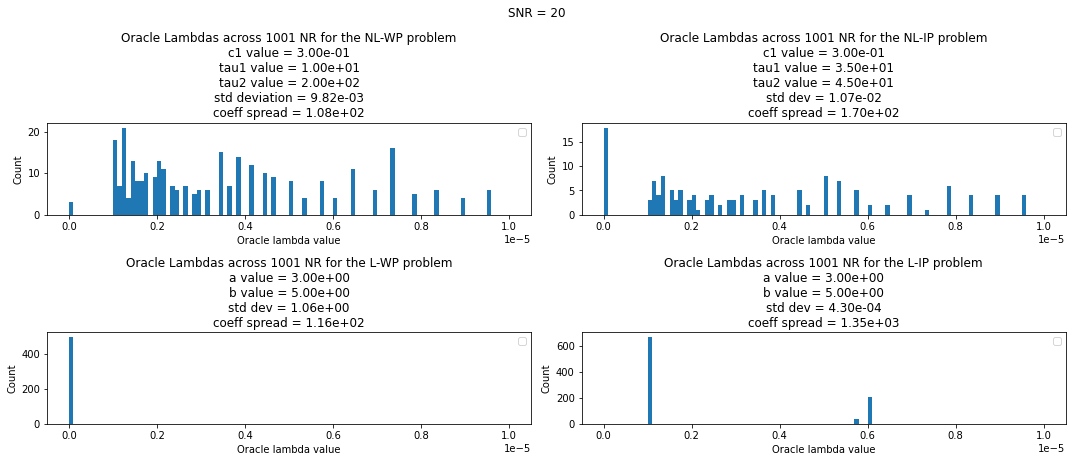

In [56]:
fig, ax = plt.subplots(2,2,figsize=(15,6.5), tight_layout=True)
fig.suptitle("SNR = 20")
NL_IPbinwidth = 0.0001
NL_WPbinwidth = 0.0001
#binwidth2 = 0.01
#NL_IPbins= np.arange(min(lam_NL_IP), max(lam_NL_IP) + NL_IPbinwidth, NL_IPbinwidth)
NL_IPbins = np.arange(0,0.00001,0.0000001)
#NL_WPbins= np.arange(min(lam_NL_WP), max(lam_NL_WP) + NL_WPbinwidth, NL_WPbinwidth)
NL_WPbins = np.arange(0,0.00001,0.0000001)

#bins2 =np.arange(min(lam_NL_WP), max(lam_NL_WP) + binwidth2, binwidth2)
ax[0,0].hist(lam_NL_WP, bins = NL_WPbins)
ax[0,0].set_xlabel("Oracle lambda value")
ax[0,0].set_ylabel("Count")
ax[0,0].set_title("Oracle Lambdas across 1001 NR for the NL-WP problem" + 
          "\nc1 value = " + "{:.2e}".format(c1_trueparam_NLWP) + 
          "\ntau1 value = " + "{:.2e}".format(tau1_trueparam_NLWP) +
          "\ntau2 value = " + "{:.2e}".format(tau2_trueparam_NLWP) +
          "\nstd deviation = " + "{:.2e}".format(st_dev(lam_NL_WP)) +
          "\ncoeff spread = " + "{:.2e}".format(coef_spread(lam_NL_WP)) 
          ) 
ax[0,0].legend()
ax[0,1].hist(lam_NL_IP, bins = NL_IPbins)
ax[0,1].set_xlabel("Oracle lambda value")
ax[0,1].set_ylabel("Count")
ax[0,1].set_title("Oracle Lambdas across 1001 NR for the NL-IP problem" + 
          "\nc1 value = " + "{:.2e}".format(c1_trueparam_NLIP) + 
          "\ntau1 value = " + "{:.2e}".format(tau1_trueparam_NLIP) +
          "\ntau2 value = " + "{:.2e}".format(tau2_trueparam_NLIP) +
          "\nstd dev = " + "{:.2e}".format(st_dev(lam_NL_IP)) +
          "\ncoeff spread = " + "{:.2e}".format(coef_spread(lam_NL_IP))
          )
ax[0,1].legend()
ax[1,0].hist(lam_L_WP, bins = NL_WPbins)
ax[1,0].set_xlabel("Oracle lambda value")
ax[1,0].set_ylabel("Count")
ax[1,0].set_title("Oracle Lambdas across 1001 NR for the L-WP problem" + 
          "\na value = " + "{:.2e}".format(lin_true_params[0]) + 
          "\nb value = " + "{:.2e}".format(lin_true_params[1])+
          "\nstd dev = " + "{:.2e}".format(st_dev(lam_L_WP)) +
          "\ncoeff spread = " + "{:.2e}".format(coef_spread(lam_L_WP))
          )
ax[1,0].legend()
ax[1,1].hist(lam_L_IP, bins = NL_IPbins)
ax[1,1].set_xlabel("Oracle lambda value")
ax[1,1].set_ylabel("Count")
ax[1,1].set_title("Oracle Lambdas across 1001 NR for the L-IP problem" + 
          "\na value = " + "{:.2e}".format(lin_true_params[0]) + 
          "\nb value = " + "{:.2e}".format(lin_true_params[1]) +
          "\nstd dev = " + "{:.2e}".format(st_dev(lam_L_IP)) +
          "\ncoeff spread = " + "{:.2e}".format(coef_spread(lam_L_IP))
          )
ax[1,1].legend()

# Visualize Data; Biexponential Non-Linear Problem


In [176]:
clean = G(t,c1,tau1,tau2)
noisy_data = add_noise(clean, SNR)


# Parameter Estimation

# Find the initial parameters that generate the lowest minimum L2 error

# Create histograms of oracle lambdas across noise realizations 

In [186]:
# n_bins = NR
# fig, axs = plt.subplots(1, 1,figsize =(10, 7), tight_layout = True)
# ax.hist(nl_ip)
# c1_trueparam_NLIP = 0.3
# tau1_trueparam_NLIP = 35
# tau2_trueparam_NLIP = 45
# plt.hist(nl_ip)
# plt.xlabel("Oracle lambda value")
# plt.ylabel("Count")
# plt.title("Oracle Lambdas across 101 NR for the NL-IP problem" + 
#           "\nc1 value = " + "{:.2e}".format(c1_trueparam_NLIP) + 
#           "\ntau1 value = " + "{:.2e}".format(tau1_trueparam_NLIP) +
#           "\ntau2 value = " + "{:.2e}".format(tau2_trueparam_NLIP))


In [28]:
#######Parameters
# NLWP
c1_trueparam_NLWP = 0.3
tau1_trueparam_NLWP = 10
tau2_trueparam_NLWP = 200
NLWP_trueparams = np.array([c1_trueparam_NLWP, tau1_trueparam_NLWP, tau2_trueparam_NLWP])

# NLIP
c1_trueparam_NLIP = 0.3
tau1_trueparam_NLIP = 35
tau2_trueparam_NLIP = 45
NLIP_trueparams = np.array([c1_trueparam_NLIP, tau1_trueparam_NLIP, tau2_trueparam_NLIP])

clean_lin_data = lin_data(true_params = lin_true_params, t_vect = t)
clean_NL_IP = G(t,c1_trueparam_NLIP,tau1_trueparam_NLIP,tau2_trueparam_NLIP)
clean_NL_WP = G(t,c1_trueparam_NLWP,tau1_trueparam_NLWP,tau2_trueparam_NLWP)


In [7]:
# NR = 101

# #Create 4 empty lists of lambda parameters
# lam_NL_WP = []
# lam_NL_IP = []
# lam_L_WP = []
# lam_L_IP = []

# #4 empty lists of parameters
# par_NL_WP = []
# par_NL_IP = []
# par_L_WP = []
# par_L_IP = []

# #4 empty lists of conditioning numbers
# cond_NL_WP = []
# cond_NL_IP = []
# cond_L_WP = []
# cond_L_IP = []

# #4 empty lists for errors 
# err_NL_WP = []
# err_NL_IP = []
# err_L_WP = []
# err_L_IP = []

# #######Parameters
# # NLWP
# c1_trueparam_NLWP = 0.3
# tau1_trueparam_NLWP = 10
# tau2_trueparam_NLWP = 200
# NLWP_trueparams = np.array([c1_trueparam_NLWP, tau1_trueparam_NLWP, tau2_trueparam_NLWP])

# # NLIP
# c1_trueparam_NLIP = 0.3
# tau1_trueparam_NLIP = 35
# tau2_trueparam_NLIP = 45
# NLIP_trueparams = np.array([c1_trueparam_NLIP, tau1_trueparam_NLIP, tau2_trueparam_NLIP])

# clean_lin_data = lin_data(true_params = lin_true_params, t_vect = t)
# clean_NL_IP = G(t,c1_trueparam_NLIP,tau1_trueparam_NLIP,tau2_trueparam_NLIP)
# clean_NL_WP = G(t,c1_trueparam_NLWP,tau1_trueparam_NLWP,tau2_trueparam_NLWP)


# for i in tqdm(range(NR)):
#     #np.random.seed(i)
#     #NL-WP
#     #clean_NL_WP = G(t,c1_trueparam_NLWP,tau1_trueparam_NLWP,tau2_trueparam_NLWP)
#     noisy_data_WP = add_noise(clean_NL_WP, SNR)
#     opt_params_comp, min_error_lambda_comp, error_array_comp, min_error_cond = find_minLambda_L2grid_omni(noisy_data_WP, NLWP_trueparams, init_params = NLWP_trueparams, lambdas = default_lambdas)
#     lam_NL_WP.append(min_error_lambda_comp)
#     par_NL_WP.append(opt_params_comp)
#     cond_NL_WP.append(min_error_cond)
#     #err_NL_WP.append(error_array_comp)

#     #NL-IP
#     #clean_NL_IP = G(t,c1_trueparam_NLIP,tau1_trueparam_NLIP,tau2_trueparam_NLIP)
#     noisy_data_IP = add_noise(clean_NL_IP, SNR)
#     opt_params_comp, min_error_lambda_comp, error_array_comp, min_error_cond = find_minLambda_L2grid_omni(noisy_data_IP, NLIP_trueparams, init_params = NLIP_trueparams, lambdas = default_lambdas)
#     lam_NL_IP.append(min_error_lambda_comp)
#     par_NL_IP.append(opt_params_comp)
#     cond_NL_IP.append(min_error_cond)
#     #err_NL_IP.append(error_array_comp)

#     #L-WP
#     #clean_lin_data_wp = lin_data(true_params = lin_true_params, t_vect = t, ill_posed = False)
#     #clean_lin_data = lin_data(true_params = lin_true_params, t_vect = t)
#     noisy_lin_signal_wp = add_noise(clean_lin_data, SNR)
#     lin_min_error_est_wp, lin_min_error_lambda_wp, lin_abs_error_list_wp, lin_cond_list_wp = find_minLambda_L2grid_linear(noisy_data = noisy_lin_signal_wp, t_vect = t, p_true = lin_true_params, lambdas = default_lambdas, ill_posed = False)
#     lam_L_WP.append(lin_min_error_lambda_wp)
#     par_L_WP.append(lin_min_error_est_wp)
#     cond_L_WP.append(lin_cond_list_wp)
#     #err_L_WP.append(lin_abs_error_list_wp)
    
#     #L-IP
#     #clean_lin_data_ip = lin_data(true_params = lin_true_params, t_vect = t, ill_posed = True)
#     noisy_lin_signal_ip = add_noise(clean_lin_data, SNR)
#     lin_min_error_est_ip, lin_min_error_lambda_ip, lin_abs_error_list_ip, lin_cond_list_ip = find_minLambda_L2grid_linear(noisy_data = noisy_lin_signal_ip, t_vect = t, p_true = lin_true_params, lambdas = default_lambdas, ill_posed = True)
#     lam_L_IP.append(lin_min_error_lambda_ip)
#     par_L_IP.append(lin_min_error_est_ip)
#     cond_L_IP.append(lin_cond_list_ip)

  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [29:48<00:00, 17.71s/it]


In [10]:
#open file (7/25 run ~6 hrs)
file = open("1001NoiseRealizations_values.txt", "w")
 
#convert variable to string
str = repr(lam_NL_WP)
file.write("lam_NL_WP = " + str + "\n")
str = repr(lam_NL_IP)
file.write("lam_NL_IP = " + str + "\n")
str = repr(lam_L_WP)
file.write("lam_L_WP = " + str + "\n")
str = repr(lam_L_IP)
file.write("lam_L_IP = " + str + "\n")

str = repr(par_NL_WP)
file.write("par_NL_WP = " + str + "\n")
str = repr(par_NL_IP)
file.write("par_NL_IP = " + str + "\n")
str = repr(par_L_WP)
file.write("par_L_WP = " + str + "\n")
str = repr(par_L_IP)
file.write("par_L_IP = " + str + "\n")

str = repr(cond_NL_WP)
file.write("cond_NL_WP = " + str + "\n")
str = repr(cond_NL_IP)
file.write("cond_NL_IP = " + str + "\n")
str = repr(cond_L_WP)
file.write("cond_L_WP = " + str + "\n")
str = repr(cond_L_IP)
file.write("cond_L_IP = " + str + "\n")

#close file
file.close()
 
f = open('1001NoiseRealizations_values.txt', 'r')
if f.mode=='r':
    contents= f.read()


In [ ]:
#check with the fit curve.
#every lambda vaule 

In [13]:
#Standard deviation and coefficient spread of lambda
def st_dev(data):
    # Calculate the standard deviation
    std_dev = np.std(data)
    return std_dev

def coef_spread(data):
    # Calculate the coefficient of spread (coefficient of variation)
    std_dev = np.std(data)
    mean = np.mean(data)
    coef_spread = (std_dev / mean) * 100  # Multiply by 100 to get percentage
    return coef_spread

In [ ]:
st_dev(lam_NL_WP)
coef_spread(lam_NL_WP)

In [9]:
len(lam_NL_WP)

1001

In [6]:
file = open("/Users/steveh/Downloads/NIH 23-24/LinearLeastSquaresAssignment/1001NoiseRealizations_values.txt", "r")
for line in file.readlines():
    print(line)
file.close()

lam_NL_WP = [5.701642722807478e-06, 0.04446312674691084, 0.030199517204020192, 5.345643593969714e-06, 1.6749428760264382e-06, 0.07447319739059889, 6.9183097091893625e-06, 6.9183097091893625e-06, 0.007798301105232585, 2.1677041048196963e-06, 1.1587773561551262e-05, 2.1677041048196963e-06, 1.2941958414499863e-06, 0.030199517204020192, 2.1677041048196963e-06, 1.2941958414499863e-06, 3.1915378551007584e-06, 0.05058246620031137, 0.0343557947899875, 7.870457896950985e-06, 0.057543993733715666, 0.0343557947899875, 7.870457896950985e-06, 0.024888573182823902, 7.870457896950985e-06, 4.1304750199016105e-06, 1.7864875748520497e-06, 0.07447319739059889, 0.07943282347242822, 5.701642722807478e-06, 0.024888573182823902, 0.01224616199265049, 1.3803842646028838e-06, 0.013931568029453036, 1.6749428760264382e-06, 8.394599865193982e-06, 0.05395106225151279, 0.03664375746478333, 6.9183097091893625e-06, 1.0864256236170644e-05, 0.0180301774085957, 0.013061708881318404, 0.04168693834703355, 0.050582466200311

In [7]:
with open('/Users/steveh/Downloads/NIH 23-24/LinearLeastSquaresAssignment/1001NoiseRealizations_values.txt') as f:
    data = {}
    for line in f:
        key, value = line.strip().split('=')
        data[key] = value

In [19]:
lam_NL_WP = [5.701642722807478e-06, 0.04446312674691084, 0.030199517204020192, 5.345643593969714e-06, 1.6749428760264382e-06, 0.07447319739059889, 6.9183097091893625e-06, 6.9183097091893625e-06, 0.007798301105232585, 2.1677041048196963e-06, 1.1587773561551262e-05, 2.1677041048196963e-06, 1.2941958414499863e-06, 0.030199517204020192, 2.1677041048196963e-06, 1.2941958414499863e-06, 3.1915378551007584e-06, 0.05058246620031137, 0.0343557947899875, 7.870457896950985e-06, 0.057543993733715666, 0.0343557947899875, 7.870457896950985e-06, 0.024888573182823902, 7.870457896950985e-06, 4.1304750199016105e-06, 1.7864875748520497e-06, 0.07447319739059889, 0.07943282347242822, 5.701642722807478e-06, 0.024888573182823902, 0.01224616199265049, 1.3803842646028838e-06, 0.013931568029453036, 1.6749428760264382e-06, 8.394599865193982e-06, 0.05395106225151279, 0.03664375746478333, 6.9183097091893625e-06, 1.0864256236170644e-05, 0.0180301774085957, 0.013061708881318404, 0.04168693834703355, 0.05058246620031137, 0.04168693834703355, 1.406047524129913e-05, 0.04446312674691084, 0.04446312674691084, 0.013931568029453036, 0.057543993733715666, 1.0864256236170644e-05, 3.404081897010009e-06, 0.0343557947899875, 1.6749428760264382e-06, 0.07447319739059889, 4.698941086052151e-06, 4.405548635065534e-06, 0.0029648313895243423, 0.057543993733715666, 0.057543993733715666, 1.6749428760264382e-06, 0.013931568029453036, 0.04446312674691084, 1.213388850464976e-06, 0.04742419852602448, 0.04446312674691084, 0.032210687912834345, 0.057543993733715666, 1.2941958414499863e-06, 0.05058246620031137, 0.032210687912834345, 0.04742419852602448, 0.0, 0.04446312674691084, 0.026546055619755416, 2.0323570109362208e-06, 3.1915378551007584e-06, 0.02831391995799379, 0.016904409316432632, 0.057543993733715666, 0.06546361740672747, 6.081350012787176e-06, 1.235947433444512e-05, 4.1304750199016105e-06, 5.345643593969714e-06, 0.02187761623949552, 1.018591388054117e-05, 0.04168693834703355, 1.066596121230257e-06, 0.057543993733715666, 1.3803842646028838e-06, 1.7864875748520497e-06, 6.486344335482388e-06, 1.5703628043335514e-06, 0.04446312674691084, 0.04446312674691084, 4.698941086052151e-06, 1.4723125024327194e-06, 1.213388850464976e-06, 0.03908408957924025, 0.0, 0.02831391995799379, 0.06982324040771719, 1.4723125024327194e-06, 1.7864875748520497e-06, 3.6307805477010175e-06, 0.023334580622810044, 2.466039337234341e-06, 0.06546361740672747, 1.137627285823431e-06, 0.08472274141405964, 0.04168693834703355, 0.023334580622810044, 0.04446312674691084, 0.061376200516479455, 0.03664375746478333, 0.08472274141405964, 0.030199517204020192, 0.057543993733715666, 1e-06, 0.032210687912834345, 1.1587773561551262e-05, 1.7060823890031244e-05, 0.010764652136298349, 0.04168693834703355, 1.137627285823431e-06, 1.066596121230257e-06, 3.404081897010009e-06, 1.213388850464976e-06, 1e-06, 2.466039337234341e-06, 0.06982324040771719, 0.061376200516479455, 5.011872336272725e-06, 1.7864875748520497e-06, 0.03908408957924025, 5.701642722807478e-06, 0.04742419852602448, 0.0343557947899875, 1.137627285823431e-06, 0.01584893192461114, 2.466039337234341e-06, 6.486344335482388e-06, 2.1677041048196963e-06, 1.1587773561551262e-05, 0.08472274141405964, 4.405548635065534e-06, 6.081350012787176e-06, 0.061376200516479455, 1.5995580286146678e-05, 0.05395106225151279, 3.1915378551007584e-06, 2.6302679918953817e-06, 0.03908408957924025, 2.6302679918953817e-06, 2.8054336379517163e-06, 0.07943282347242822, 6.081350012787176e-06, 3.6307805477010175e-06, 0.030199517204020192, 6.9183097091893625e-06, 6.9183097091893625e-06, 3.6307805477010175e-06, 0.026546055619755416, 0.024888573182823902, 0.05058246620031137, 0.04446312674691084, 9.549925860214369e-06, 0.057543993733715666, 0.06982324040771719, 0.04446312674691084, 0.09036494737223023, 2.8054336379517163e-06, 0.04168693834703355, 1.3803842646028838e-06, 6.9183097091893625e-06, 0.06982324040771719, 1.018591388054117e-05, 2.6302679918953817e-06, 0.01148153621496884, 1.1587773561551262e-05, 2.8054336379517163e-06, 0.02187761623949552, 0.04168693834703355, 0.030199517204020192, 0.032210687912834345, 0.061376200516479455, 0.032210687912834345, 0.03908408957924025, 1.3182567385564074e-05, 0.05395106225151279, 1.213388850464976e-06, 0.03908408957924025, 1.213388850464976e-06, 0.032210687912834345, 0.032210687912834345, 5.011872336272725e-06, 9.549925860214369e-06, 0.0343557947899875, 5.345643593969714e-06, 1.137627285823431e-06, 1.4996848355023741e-05, 2.1677041048196963e-06, 0.0343557947899875, 0.07447319739059889, 6.9183097091893625e-06, 1.9054607179632483e-06, 0.07447319739059889, 3.6307805477010175e-06, 0.05395106225151279, 0.024888573182823902, 0.05395106225151279, 3.404081897010009e-06, 2.8054336379517163e-06, 0.03908408957924025, 0.06982324040771719, 1.137627285823431e-06, 5.701642722807478e-06, 1.9054607179632483e-06, 0.0343557947899875, 0.03908408957924025, 1.5703628043335514e-06, 0.03664375746478333, 0.07943282347242822, 1.6749428760264382e-06, 1.406047524129913e-05, 0.061376200516479455, 0.02831391995799379, 0.04168693834703355, 7.870457896950985e-06, 0.04446312674691084, 1e-06, 4.698941086052151e-06, 7.379042301291015e-06, 0.03908408957924025, 0.05395106225151279, 0.07943282347242822, 0.0343557947899875, 1.7864875748520497e-06, 0.0180301774085957, 4.698941086052151e-06, 0.03908408957924025, 2.0323570109362208e-06, 0.04168693834703355, 4.1304750199016105e-06, 0.0180301774085957, 0.0, 0.04168693834703355, 7.870457896950985e-06, 0.05395106225151279, 1.066596121230257e-06, 1.213388850464976e-06, 1.235947433444512e-05, 0.0343557947899875, 2.466039337234341e-06, 1.9054607179632483e-06, 1.5995580286146678e-05, 0.026546055619755416, 0.030199517204020192, 0.04168693834703355, 0.04168693834703355, 8.953647655495937e-06, 7.870457896950985e-06, 0.023334580622810044, 1.3803842646028838e-06, 0.030199517204020192, 2.8054336379517163e-06, 1.3803842646028838e-06, 0.05395106225151279, 0.030199517204020192, 0.03908408957924025, 2.8054336379517163e-06, 2.466039337234341e-06, 1.213388850464976e-06, 0.014859356422870059, 2.1677041048196963e-06, 0.02831391995799379, 4.405548635065534e-06, 0.02831391995799379, 1.137627285823431e-06, 1.7060823890031244e-05, 3.404081897010009e-06, 2.1677041048196963e-06, 4.1304750199016105e-06, 1.7864875748520497e-06, 0.04446312674691084, 7.870457896950985e-06, 0.06546361740672747, 0.02831391995799379, 2.6302679918953817e-06, 2.466039337234341e-06, 0.02831391995799379, 0.06982324040771719, 1.1587773561551262e-05, 1.137627285823431e-06, 9.549925860214369e-06, 0.014859356422870059, 0.07943282347242822, 0.014859356422870059, 0.03908408957924025, 0.030199517204020192, 0.05395106225151279, 0.06982324040771719, 0.04742419852602448, 2.6302679918953817e-06, 1.137627285823431e-06, 5.701642722807478e-06, 1.4723125024327194e-06, 0.061376200516479455, 0.026546055619755416, 2.992264636608189e-06, 0.04742419852602448, 1.6749428760264382e-06, 0.04742419852602448, 1.066596121230257e-06, 0.02187761623949552, 0.04446312674691084, 0.05058246620031137, 0.03664375746478333, 0.10280162981264745, 0.04446312674691084, 1.2941958414499863e-06, 1.5703628043335514e-06, 1e-06, 0.057543993733715666, 5.701642722807478e-06, 0.04446312674691084, 0.04446312674691084, 0.04446312674691084, 0.030199517204020192, 0.06982324040771719, 0.02187761623949552, 0.061376200516479455, 5.701642722807478e-06, 4.1304750199016105e-06, 2.8054336379517163e-06, 1.6749428760264382e-06, 4.405548635065534e-06, 0.026546055619755416, 2.466039337234341e-06, 0.032210687912834345, 0.04446312674691084, 6.9183097091893625e-06, 1.5703628043335514e-06, 6.9183097091893625e-06, 0.0035974933515574236, 7.870457896950985e-06, 1.9054607179632483e-06, 0.061376200516479455, 1.2941958414499863e-06, 0.007798301105232585, 7.379042301291015e-06, 0.04446312674691084, 0.061376200516479455, 0.057543993733715666, 0.032210687912834345, 0.02831391995799379, 1.066596121230257e-06, 0.016904409316432632, 4.405548635065534e-06, 5.701642722807478e-06, 1.5703628043335514e-06, 4.1304750199016105e-06, 0.06982324040771719, 0.009462371613657929, 2.992264636608189e-06, 0.0, 4.1304750199016105e-06, 2.1677041048196963e-06, 8.394599865193982e-06, 1e-06, 0.04446312674691084, 3.1915378551007584e-06, 0.02187761623949552, 2.992264636608189e-06, 4.405548635065534e-06, 3.404081897010009e-06, 0.05395106225151279, 1.235947433444512e-05, 0.03664375746478333, 0.057543993733715666, 0.016904409316432632, 0.08472274141405964, 1.2941958414499863e-06, 2.312064790175594e-06, 5.345643593969714e-06, 0.04168693834703355, 0.0, 0.0, 0.06982324040771719, 0.07943282347242822, 0.01584893192461114, 0.06546361740672747, 1.7060823890031244e-05, 0.03908408957924025, 0.032210687912834345, 0.08472274141405964, 0.08472274141405964, 1.0864256236170644e-05, 1.0864256236170644e-05, 1.137627285823431e-06, 6.486344335482388e-06, 2.2080047330189015e-05, 2.0323570109362208e-06, 0.03664375746478333, 0.03908408957924025, 0.03908408957924025, 0.02187761623949552, 9.549925860214369e-06, 2.2080047330189015e-05, 0.04168693834703355, 4.698941086052151e-06, 0.07447319739059889, 3.8725764492161726e-06, 0.04742419852602448, 1e-06, 0.05395106225151279, 0.06546361740672747, 0.05058246620031137, 0.008317637711026709, 0.024888573182823902, 1.7060823890031244e-05, 0.05058246620031137, 1.018591388054117e-05, 3.6307805477010175e-06, 0.057543993733715666, 0.032210687912834345, 4.405548635065534e-06, 0.05395106225151279, 0.0, 0.02831391995799379, 0.05058246620031137, 1.406047524129913e-05, 0.057543993733715666, 0.0, 2.0323570109362208e-06, 1.5703628043335514e-06, 3.1915378551007584e-06, 1.7864875748520497e-06, 4.1304750199016105e-06, 0.05395106225151279, 0.0343557947899875, 3.1915378551007584e-06, 0.05395106225151279, 9.549925860214369e-06, 0.03908408957924025, 2.992264636608189e-06, 4.405548635065534e-06, 1.066596121230257e-06, 0.061376200516479455, 4.698941086052151e-06, 5.011872336272725e-06, 1.066596121230257e-06, 1.9054607179632483e-06, 0.03908408957924025, 0.02187761623949552, 0.032210687912834345, 1.1587773561551262e-05, 0.02831391995799379, 0.04446312674691084, 2.0323570109362208e-06, 0.03664375746478333, 0.013931568029453036, 0.061376200516479455, 0.04446312674691084, 0.06982324040771719, 0.0343557947899875, 2.466039337234341e-06, 0.0, 0.0343557947899875, 0.03664375746478333, 0.08472274141405964, 0.05395106225151279, 1.0864256236170644e-05, 3.6307805477010175e-06, 0.08472274141405964, 0.014859356422870059, 5.345643593969714e-06, 0.057543993733715666, 3.404081897010009e-06, 0.06546361740672747, 3.8725764492161726e-06, 0.04742419852602448, 0.04168693834703355, 8.394599865193982e-06, 0.016904409316432632, 0.03908408957924025, 0.02831391995799379, 0.010764652136298349, 1.018591388054117e-05, 3.1915378551007584e-06, 0.05058246620031137, 0.04168693834703355, 0.07943282347242822, 0.06546361740672747, 0.06982324040771719, 5.345643593969714e-06, 0.02831391995799379, 2.8575905433749437e-05, 0.02831391995799379, 0.05058246620031137, 5.345643593969714e-06, 0.032210687912834345, 1.0864256236170644e-05, 0.05395106225151279, 0.07447319739059889, 0.057543993733715666, 1.3803842646028838e-06, 7.870457896950985e-06, 0.07447319739059889, 0.061376200516479455, 0.05058246620031137, 2.2080047330189015e-05, 1.213388850464976e-06, 1.7060823890031244e-05, 0.03908408957924025, 0.0, 1.9054607179632483e-06, 3.6307805477010175e-06, 0.07943282347242822, 0.014859356422870059, 0.04742419852602448, 3.250872973854347e-05, 4.405548635065534e-06, 0.08472274141405964, 0.014859356422870059, 0.06546361740672747, 2.1677041048196963e-06, 0.005296634438916581, 0.03908408957924025, 0.024888573182823902, 1.213388850464976e-06, 0.061376200516479455, 4.405548635065534e-06, 6.081350012787176e-06, 3.1915378551007584e-06, 1.6749428760264382e-06, 2.0323570109362208e-06, 0.06982324040771719, 1.6749428760264382e-06, 0.07447319739059889, 1.5703628043335514e-06, 0.0060255958607435805, 2.355049283896009e-05, 0.03908408957924025, 0.0343557947899875, 0.061376200516479455, 0.03908408957924025, 1.5703628043335514e-06, 0.06546361740672747, 0.03664375746478333, 0.05058246620031137, 9.549925860214369e-06, 0.0343557947899875, 5.011872336272725e-06, 7.870457896950985e-06, 0.032210687912834345, 0.05058246620031137, 4.405548635065534e-06, 1.213388850464976e-06, 2.2080047330189015e-05, 2.0323570109362208e-06, 1.0864256236170644e-05, 0.01584893192461114, 5.011872336272725e-06, 8.394599865193982e-06, 0.061376200516479455, 0.04446312674691084, 1.2941958414499863e-06, 2.8054336379517163e-06, 0.03908408957924025, 0.09638290236239705, 0.09638290236239705, 2.1677041048196963e-06, 5.701642722807478e-06, 0.061376200516479455, 1.9408858775927792e-05, 1.5995580286146678e-05, 0.026546055619755416, 2.312064790175594e-06, 0.06982324040771719, 0.05395106225151279, 0.057543993733715666, 0.03664375746478333, 0.05395106225151279, 1.8197008586099827e-05, 7.379042301291015e-06, 2.1677041048196963e-06, 5.701642722807478e-06, 0.06982324040771719, 2.0323570109362208e-06, 2.6302679918953817e-06, 0.030199517204020192, 0.02831391995799379, 1.8197008586099827e-05, 0.032210687912834345, 0.032210687912834345, 1.2941958414499863e-06, 0.007311390834834172, 5.345643593969714e-06, 1.4723125024327194e-06, 1.9408858775927792e-05, 0.032210687912834345, 0.05058246620031137, 7.870457896950985e-06, 1.9054607179632483e-06, 0.08472274141405964, 2.6302679918953817e-06, 5.345643593969714e-06, 7.379042301291015e-06, 6.9183097091893625e-06, 0.06982324040771719, 1.5703628043335514e-06, 0.10280162981264745, 6.081350012787176e-06, 0.07447319739059889, 0.0180301774085957, 0.01148153621496884, 0.07943282347242822, 2.2080047330189015e-05, 0.06982324040771719, 0.07447319739059889, 0.010092528860766855, 0.06546361740672747, 1.2941958414499863e-06, 4.405548635065534e-06, 0.09036494737223023, 9.549925860214369e-06, 2.0323570109362208e-06, 0.02831391995799379, 1.213388850464976e-06, 0.05395106225151279, 0.05058246620031137, 1.7060823890031244e-05, 3.1915378551007584e-06, 0.04168693834703355, 1.1587773561551262e-05, 0.01584893192461114, 8.394599865193982e-06, 2.355049283896009e-05, 4.405548635065534e-06, 0.010764652136298349, 0.04446312674691084, 5.345643593969714e-06, 0.016904409316432632, 0.026546055619755416, 0.0180301774085957, 2.0323570109362208e-06, 1.7864875748520497e-06, 1.5703628043335514e-06, 0.026546055619755416, 0.057543993733715666, 0.10280162981264745, 0.026546055619755416, 1.9054607179632483e-06, 3.404081897010009e-06, 0.026546055619755416, 8.953647655495937e-06, 0.03908408957924025, 2.466039337234341e-06, 0.057543993733715666, 2.466039337234341e-06, 7.379042301291015e-06, 4.698941086052151e-06, 0.06546361740672747, 2.312064790175594e-06, 0.04742419852602448, 1.4723125024327194e-06, 1.7864875748520497e-06, 0.05395106225151279, 0.04446312674691084, 0.04168693834703355, 2.0323570109362208e-06, 2.6302679918953817e-06, 1.7864875748520497e-06, 0.016904409316432632, 0.030199517204020192, 3.404081897010009e-06, 0.05058246620031137, 1.213388850464976e-06, 4.698941086052151e-06, 2.6302679918953817e-06, 3.1915378551007584e-06, 1.1587773561551262e-05, 1.066596121230257e-06, 1.0864256236170644e-05, 6.081350012787176e-06, 0.02831391995799379, 2.0323570109362208e-06, 0.061376200516479455, 0.07447319739059889, 0.020511621788255666, 1.137627285823431e-06, 0.03908408957924025, 0.04446312674691084, 0.06982324040771719, 1.9054607179632483e-06, 3.6307805477010175e-06, 0.06982324040771719, 0.05058246620031137, 5.345643593969714e-06, 0.061376200516479455, 0.05395106225151279, 8.394599865193982e-06, 0.020511621788255666, 7.870457896950985e-06, 1.1587773561551262e-05, 0.0, 0.04742419852602448, 0.057543993733715666, 2.992264636608189e-06, 1.066596121230257e-06, 0.026546055619755416, 0.03908408957924025, 0.03664375746478333, 3.6307805477010175e-06, 0.05058246620031137, 0.06546361740672747, 4.698941086052151e-06, 0.003837072454922788, 0.06546361740672747, 8.953647655495937e-06, 9.549925860214369e-06, 0.02831391995799379, 0.05395106225151279, 0.03908408957924025, 1.7864875748520497e-06, 1.4723125024327194e-06, 1.066596121230257e-06, 8.394599865193982e-06, 1.3803842646028838e-06, 2.6302679918953817e-06, 0.04742419852602448, 9.549925860214369e-06, 0.030199517204020192, 0.030199517204020192, 1.5995580286146678e-05, 0.06982324040771719, 8.953647655495937e-06, 3.6307805477010175e-06, 0.03664375746478333, 0.05395106225151279, 0.09638290236239705, 2.312064790175594e-06, 0.02831391995799379, 0.019230917289101576, 0.08472274141405964, 2.8054336379517163e-06, 7.870457896950985e-06, 0.04446312674691084, 0.04446312674691084, 0.06982324040771719, 0.06982324040771719, 0.04742419852602448, 0.032210687912834345, 9.549925860214369e-06, 5.345643593969714e-06, 1.5703628043335514e-06, 0.061376200516479455, 3.404081897010009e-06, 0.02831391995799379, 0.06982324040771719, 3.1915378551007584e-06, 1e-06, 0.07943282347242822, 0.04742419852602448, 1.3803842646028838e-06, 3.1915378551007584e-06, 0.04742419852602448, 1.137627285823431e-06, 1.9408858775927792e-05, 1.9408858775927792e-05, 7.870457896950985e-06, 0.04742419852602448, 5.011872336272725e-06, 1.137627285823431e-06, 0.057543993733715666, 0.03908408957924025, 0.057543993733715666, 0.06982324040771719, 0.032210687912834345, 3.1915378551007584e-06, 0.06546361740672747, 1e-06, 3.404081897010009e-06, 0.06982324040771719, 3.404081897010009e-06, 0.09638290236239705, 0.057543993733715666, 0.05058246620031137, 0.04446312674691084, 0.026546055619755416, 1.0864256236170644e-05, 0.06546361740672747, 0.057543993733715666, 0.005296634438916581, 0.010092528860766855, 0.061376200516479455, 5.701642722807478e-06, 1.4723125024327194e-06, 1.3803842646028838e-06, 0.04742419852602448, 0.04168693834703355, 5.345643593969714e-06, 1.0864256236170644e-05, 3.1915378551007584e-06, 1.406047524129913e-05, 1.1587773561551262e-05, 0.061376200516479455, 0.03908408957924025, 1.137627285823431e-06, 0.06982324040771719, 0.04742419852602448, 0.04168693834703355, 1.3803842646028838e-06, 4.698941086052151e-06, 0.05058246620031137, 1.406047524129913e-05, 2.312064790175594e-06, 2.6302679918953817e-06, 0.07943282347242822, 0.05395106225151279, 0.05395106225151279, 1.2941958414499863e-06, 0.057543993733715666, 1e-06, 1.4723125024327194e-06, 3.8725764492161726e-06, 0.07447319739059889, 0.0060255958607435805, 1.066596121230257e-06, 0.030199517204020192, 2.466039337234341e-06, 1.213388850464976e-06, 2.6302679918953817e-06, 0.023334580622810044, 2.992264636608189e-06, 0.03908408957924025, 0.057543993733715666, 2.8054336379517163e-06, 0.061376200516479455, 0.03908408957924025, 0.04168693834703355, 0.05395106225151279, 1.3803842646028838e-06, 0.07943282347242822, 0.032210687912834345, 0.026546055619755416, 0.06982324040771719, 6.9183097091893625e-06, 0.04446312674691084, 5.345643593969714e-06, 0.09036494737223023, 0.06982324040771719, 6.9183097091893625e-06, 1.2941958414499863e-06, 2.1677041048196963e-06, 2.0701413487910412e-05, 0.061376200516479455, 2.8054336379517163e-06, 1.1587773561551262e-05, 0.010092528860766855, 5.011872336272725e-06, 1.213388850464976e-06, 0.06546361740672747, 0.05058246620031137, 2.6791683248190313e-05, 0.016904409316432632, 1.235947433444512e-05, 0.09036494737223023, 5.701642722807478e-06, 0.032210687912834345, 0.08472274141405964, 0.061376200516479455, 0.023334580622810044, 3.1915378551007584e-06, 6.9183097091893625e-06, 0.04742419852602448, 0.03664375746478333, 1.5995580286146678e-05, 2.8054336379517163e-06, 3.6307805477010175e-06, 2.466039337234341e-06, 0.06546361740672747, 1.066596121230257e-06, 0.023334580622810044, 0.04168693834703355, 0.061376200516479455, 0.06982324040771719, 0.057543993733715666, 0.09036494737223023, 0.05058246620031137, 0.03664375746478333, 0.06546361740672747, 1.3803842646028838e-06, 1.3803842646028838e-06, 5.345643593969714e-06, 1.137627285823431e-06, 0.05058246620031137, 2.6302679918953817e-06, 0.06982324040771719, 1.137627285823431e-06, 1.5703628043335514e-06, 0.05058246620031137, 0.08472274141405964, 6.081350012787176e-06, 0.04742419852602448, 0.061376200516479455, 0.057543993733715666, 0.013061708881318404, 5.345643593969714e-06, 0.023334580622810044, 2.8054336379517163e-06, 0.04742419852602448, 3.6307805477010175e-06, 0.023334580622810044, 3.6307805477010175e-06, 1.4723125024327194e-06, 2.312064790175594e-06, 0.07447319739059889, 1.5703628043335514e-06, 0.05395106225151279, 1.2941958414499863e-06, 1.4996848355023741e-05, 0.03664375746478333, 0.06546361740672747, 6.9183097091893625e-06, 0.04168693834703355, 0.032210687912834345, 2.992264636608189e-06, 1.4996848355023741e-05, 0.0, 7.379042301291015e-06, 0.03664375746478333, 0.08472274141405964, 0.06546361740672747, 0.057543993733715666, 1.4996848355023741e-05, 7.870457896950985e-06, 3.1915378551007584e-06, 0.05395106225151279, 2.312064790175594e-06, 0.05395106225151279, 0.020511621788255666, 1.9408858775927792e-05, 1.0864256236170644e-05, 1.5703628043335514e-06, 0.013061708881318404, 0.04742419852602448, 0.026546055619755416, 2.466039337234341e-06, 0.032210687912834345, 0.061376200516479455, 1.6749428760264382e-06, 0.04168693834703355, 6.081350012787176e-06, 6.486344335482388e-06, 5.011872336272725e-06, 0.0060255958607435805, 8.394599865193982e-06, 0.05395106225151279, 1.6749428760264382e-06, 0.05395106225151279, 0.03664375746478333, 0.04168693834703355, 1.0864256236170644e-05, 1.0864256236170644e-05, 6.9183097091893625e-06, 0.05395106225151279, 0.04168693834703355, 0.07447319739059889, 0.057543993733715666, 0.05395106225151279, 0.003372873086588689, 0.04742419852602448, 0.061376200516479455, 1.018591388054117e-05, 0.02831391995799379, 0.0180301774085957, 0.023334580622810044, 0.061376200516479455, 0.057543993733715666, 0.01584893192461114, 4.1304750199016105e-06, 0.032210687912834345, 0.061376200516479455, 0.007311390834834172, 0.03664375746478333, 6.486344335482388e-06, 0.05395106225151279, 0.030199517204020192, 0.02187761623949552, 0.04446312674691084, 4.1304750199016105e-06, 0.057543993733715666, 0.07447319739059889, 0.07447319739059889, 0.057543993733715666, 0.04742419852602448, 0.04168693834703355, 2.2080047330189015e-05]

lam_NL_IP = [0.08472274141405964, 1.018591388054117e-05, 0.02831391995799379, 0.0013677288255958494, 0.0004570881896148752, 0.00042854852039743966, 5.1050499997540645e-05, 0.013931568029453036, 1.2941958414499863e-06, 2.6791683248190313e-05, 0.0007177942912713615, 0.00018535316234148124, 1.5995580286146678e-05, 3.404081897010009e-06, 0.0020137242498623896, 0.00042854852039743966, 0.05058246620031137, 2.355049283896009e-05, 1.3182567385564074e-05, 2.0701413487910412e-05, 6.9183097091893625e-06, 0.001202264434617413, 4.1304750199016105e-06, 0.004655860935229591, 0.030199517204020192, 2.0701413487910412e-05, 0.04168693834703355, 2.8575905433749437e-05, 0.001555965631605075, 0.013061708881318404, 0.05395106225151279, 0.0012823305826560219, 9.549925860214369e-06, 0.057543993733715666, 0.009462371613657929, 0.008317637711026709, 1.213388850464976e-06, 0.0029648313895243423, 0.0013677288255958494, 3.6307805477010175e-06, 0.0018879913490962945, 0.00040179081084894003, 1.4723125024327194e-06, 1.7060823890031244e-05, 1.2941958414499863e-06, 5.011872336272725e-06, 0.0010568175092136585, 6.9183097091893625e-06, 1.1587773561551262e-05, 0.0006729766562843175, 8.394599865193982e-06, 0.004965923214503363, 0.04168693834703355, 0.0008709635899560805, 0.023334580622810044, 0.0029648313895243423, 0.0, 5.345643593969714e-06, 0.03908408957924025, 0.001202264434617413, 0.0013677288255958494, 0.003372873086588689, 1.9408858775927792e-05, 0.014859356422870059, 0.0009908319448927675, 0.0020137242498623896, 0.0012823305826560219, 4.405548635065534e-06, 0.001555965631605075, 7.046930689671467e-05, 0.0018879913490962945, 0.001202264434617413, 0.07943282347242822, 0.0024434305526939712, 0.003837072454922788, 0.0020137242498623896, 0.010092528860766855, 0.001770108958317422, 0.0005915616341754743, 0.013061708881318404, 0.0022908676527677724, 3.404081897010009e-06, 0.0007177942912713615, 8.394599865193982e-06, 1.1587773561551262e-05, 1.9054607179632483e-06, 1.2941958414499863e-06, 0.019230917289101576, 0.05058246620031137, 6.486344335482388e-06, 4.405548635065534e-06, 2.2080047330189015e-05, 0.02187761623949552, 0.004655860935229591, 0.01584893192461114, 0.001202264434617413, 0.0007177942912713615, 0.0, 2.6302679918953817e-06, 0.024888573182823902, 0.0, 1.5703628043335514e-06, 0.02187761623949552, 0.008871560120379608, 0.0020137242498623896, 2.466039337234341e-06, 0.005296634438916581, 0.057543993733715666, 0.004655860935229591, 0.001458814260275349, 8.394599865193982e-06, 0.0060255958607435805, 0.007798301105232585, 0.01148153621496884, 0.024888573182823902, 0.0018879913490962945, 1.406047524129913e-05, 0.003837072454922788, 2.0323570109362208e-06, 0.004365158322401661, 0.010764652136298349, 0.05058246620031137, 0.0013677288255958494, 8.394599865193982e-06, 0.07943282347242822, 0.003837072454922788, 0.03908408957924025, 0.0, 0.0005915616341754743, 0.001770108958317422, 0.0012823305826560219, 0.02187761623949552, 0.026546055619755416, 0.02831391995799379, 0.0016595869074375613, 1.6749428760264382e-06, 0.023334580622810044, 0.0021478304741305333, 0.0011271974561755105, 0.026546055619755416, 0.00012589254117941674, 0.0016595869074375613, 1.137627285823431e-06, 0.003372873086588689, 7.379042301291015e-06, 0.010092528860766855, 0.0013677288255958494, 0.057543993733715666, 0.0006309573444801936, 7.379042301291015e-06, 0.001770108958317422, 7.870457896950985e-06, 7.870457896950985e-06, 0.020511621788255666, 0.026546055619755416, 0.0031622776601683794, 0.030199517204020192, 0.06982324040771719, 0.005296634438916581, 0.016904409316432632, 0.005649369748123028, 0.05058246620031137, 1.0864256236170644e-05, 1.406047524129913e-05, 0.061376200516479455, 1e-06, 0.03664375746478333, 2.1677041048196963e-06, 0.0180301774085957, 0.0020137242498623896, 0.019230917289101576, 0.00042854852039743966, 0.1096478196143185, 0.008871560120379608, 0.013061708881318404, 1.213388850464976e-06, 7.870457896950985e-06, 0.00042854852039743966, 1.8197008586099827e-05, 0.001770108958317422, 0.001202264434617413, 0.0180301774085957, 1.4996848355023741e-05, 2.8054336379517163e-06, 0.0029648313895243423, 2.0323570109362208e-06, 0.04742419852602448, 7.870457896950985e-06, 0.001458814260275349, 2.6302679918953817e-06, 0.05058246620031137, 0.004655860935229591, 1.9408858775927792e-05, 0.03908408957924025, 0.030199517204020192, 0.0027797132677592883, 1.137627285823431e-06, 0.0006729766562843175, 9.549925860214369e-06, 0.07447319739059889, 0.016904409316432632, 0.0035974933515574236, 0.001555965631605075, 0.010764652136298349, 0.00018535316234148124, 4.1304750199016105e-06, 0.0007177942912713615, 0.0007177942912713615, 0.06546361740672747, 0.0009908319448927675, 0.019230917289101576, 4.698941086052151e-06, 6.606934480075965e-05, 2.466039337234341e-06, 0.02831391995799379, 2.992264636608189e-06, 0.0013677288255958494, 0.0012823305826560219, 0.00409260659730011, 0.0020137242498623896, 6.486344335482388e-06, 0.0018879913490962945, 1.066596121230257e-06, 0.04446312674691084, 0.0029648313895243423, 0.01584893192461114, 2.466039337234341e-06, 0.0009289663867799362, 0.01148153621496884, 0.0031622776601683794, 0.00012589254117941674, 0.008871560120379608, 0.0004875284901033865, 0.0027797132677592883, 3.404081897010009e-06, 0.0021478304741305333, 0.002606153549998895, 7.870457896950985e-06, 0.0010568175092136585, 0.014859356422870059, 0.0016595869074375613, 0.005649369748123028, 0.0021478304741305333, 0.019230917289101576, 0.0007177942912713615, 0.0010568175092136585, 0.0009908319448927675, 0.04168693834703355, 1.235947433444512e-05, 1.9408858775927792e-05, 0.004655860935229591, 0.0005915616341754743, 0.026546055619755416, 2.312064790175594e-06, 0.0020137242498623896, 1.018591388054117e-05, 6.486344335482388e-06, 0.0004570881896148752, 0.0013677288255958494, 0.03664375746478333, 6.081350012787176e-06, 0.003837072454922788, 0.0003767037989839089, 0.01584893192461114, 0.0022908676527677724, 0.001458814260275349, 0.0001342764961137864, 0.007798301105232585, 2.2080047330189015e-05, 0.02187761623949552, 0.0029648313895243423, 0.04446312674691084, 3.9445730207527845e-05, 0.020511621788255666, 1.213388850464976e-06, 0.0016595869074375613, 0.0180301774085957, 0.023334580622810044, 0.014859356422870059, 1e-06, 0.0018879913490962945, 0.03664375746478333, 0.0016595869074375613, 0.06982324040771719, 0.06546361740672747, 0.00409260659730011, 5.1050499997540645e-05, 1e-06, 0.023334580622810044, 0.024888573182823902, 0.024888573182823902, 0.014859356422870059, 0.0003767037989839089, 0.03908408957924025, 0.0, 0.0, 0.0020137242498623896, 0.00042854852039743966, 0.0016595869074375613, 0.000353183169791957, 0.0035974933515574236, 0.000353183169791957, 0.0060255958607435805, 0.001555965631605075, 0.0010568175092136585, 2.6302679918953817e-06, 0.07447319739059889, 0.0021478304741305333, 1.018591388054117e-05, 4.487453899331323e-05, 4.1304750199016105e-06, 1.9408858775927792e-05, 0.0035974933515574236, 0.0013677288255958494, 0.0, 0.0, 0.0016595869074375613, 0.013931568029453036, 0.0009908319448927675, 0.0010568175092136585, 0.0020137242498623896, 0.0009289663867799362, 0.0003767037989839089, 0.010764652136298349, 4.405548635065534e-06, 0.013061708881318404, 0.0016595869074375613, 0.02187761623949552, 0.0011271974561755105, 4.1304750199016105e-06, 0.0013677288255958494, 2.2080047330189015e-05, 1.7060823890031244e-05, 0.0009289663867799362, 0.0007655966069112562, 0.0035974933515574236, 0.024888573182823902, 0.002606153549998895, 0.004965923214503363, 0.00409260659730011, 0.020511621788255666, 0.0012823305826560219, 0.013061708881318404, 0.032210687912834345, 1.7060823890031244e-05, 0.04742419852602448, 0.057543993733715666, 0.007798301105232585, 0.0001527566058238073, 0.09036494737223023, 0.005296634438916581, 0.0011271974561755105, 0.00040179081084894003, 0.01584893192461114, 0.05058246620031137, 2.355049283896009e-05, 0.001555965631605075, 1.3803842646028838e-06, 1.5703628043335514e-06, 0.032210687912834345, 0.0018879913490962945, 0.02187761623949552, 0.0009289663867799362, 0.0007655966069112562, 5.011872336272725e-06, 0.0008165823713585923, 0.0011271974561755105, 0.024888573182823902, 7.379042301291015e-06, 0.0001629296032639723, 0.020511621788255666, 7.379042301291015e-06, 3.6307805477010175e-06, 2.5118864315095822e-05, 0.0035974933515574236, 0.07943282347242822, 0.02831391995799379, 0.001770108958317422, 0.024888573182823902, 1.066596121230257e-06, 0.09036494737223023, 0.000554625712957911, 0.0, 1.137627285823431e-06, 1.066596121230257e-06, 0.001202264434617413, 0.0008709635899560805, 0.002606153549998895, 8.01678063387679e-05, 3.1915378551007584e-06, 5.445026528424209e-05, 0.024888573182823902, 0.03664375746478333, 1.066596121230257e-06, 0.00011066237839776664, 0.0060255958607435805, 3.8725764492161726e-06, 0.00409260659730011, 2.992264636608189e-06, 0.030199517204020192, 6.9183097091893625e-06, 0.02187761623949552, 0.0064268771731702005, 0.00042854852039743966, 0.0007655966069112562, 3.1915378551007584e-06, 2.312064790175594e-06, 6.486344335482388e-06, 6.9183097091893625e-06, 0.0020137242498623896, 0.06546361740672747, 0.0012823305826560219, 0.0012823305826560219, 0.0010568175092136585, 0.013061708881318404, 0.0, 0.0007177942912713615, 0.04742419852602448, 0.0018879913490962945, 0.001202264434617413, 5.701642722807478e-06, 2.355049283896009e-05, 0.007311390834834172, 1.018591388054117e-05, 0.030199517204020192, 8.394599865193982e-06, 0.030199517204020192, 0.02187761623949552, 0.0060255958607435805, 0.0013677288255958494, 2.0701413487910412e-05, 1.3803842646028838e-06, 0.032210687912834345, 0.007311390834834172, 0.0, 0.001202264434617413, 0.019230917289101576, 0.0005915616341754743, 0.007798301105232585, 0.0021478304741305333, 0.024888573182823902, 1.3182567385564074e-05, 3.9445730207527845e-05, 2.312064790175594e-06, 0.0021478304741305333, 0.04446312674691084, 0.000554625712957911, 0.0018879913490962945, 1.2941958414499863e-06, 0.019230917289101576, 8.953647655495937e-06, 0.014859356422870059, 0.0018879913490962945, 0.0013677288255958494, 0.020511621788255666, 0.05395106225151279, 0.01148153621496884, 1.9054607179632483e-06, 0.057543993733715666, 0.001770108958317422, 0.0009289663867799362, 0.0064268771731702005, 0.05395106225151279, 0.06982324040771719, 0.016904409316432632, 0.05058246620031137, 3.6307805477010175e-06, 1.137627285823431e-06, 3.404081897010009e-06, 9.120108393559096e-05, 0.0006729766562843175, 0.06982324040771719, 0.000353183169791957, 0.0008165823713585923, 0.006854882264526621, 3.8725764492161726e-06, 0.00018535316234148124, 0.0001342764961137864, 2.992264636608189e-06, 0.03908408957924025, 0.016904409316432632, 1.4723125024327194e-06, 0.0012823305826560219, 0.007311390834834172, 0.0007655966069112562, 1.406047524129913e-05, 0.08472274141405964, 5.445026528424209e-05, 0.061376200516479455, 0.0020137242498623896, 9.549925860214369e-06, 0.032210687912834345, 0.0007655966069112562, 0.024888573182823902, 2.312064790175594e-06, 0.03908408957924025, 0.0011271974561755105, 0.04446312674691084, 0.0029648313895243423, 0.0010568175092136585, 7.379042301291015e-06, 5.1050499997540645e-05, 0.00042854852039743966, 0.00027289777828080403, 0.0, 0.05058246620031137, 0.05058246620031137, 0.004965923214503363, 0.04742419852602448, 0.0007177942912713615, 0.0024434305526939712, 0.0006729766562843175, 0.05058246620031137, 0.0008709635899560805, 0.0010568175092136585, 1.213388850464976e-06, 4.2072662838444464e-05, 4.1304750199016105e-06, 0.0, 0.04742419852602448, 0.0003311311214825911, 2.992264636608189e-06, 1.3803842646028838e-06, 0.09638290236239705, 0.0007655966069112562, 3.8725764492161726e-06, 0.0012823305826560219, 0.0008165823713585923, 0.0016595869074375613, 0.014859356422870059, 0.006854882264526621, 4.405548635065534e-06, 0.057543993733715666, 0.0003767037989839089, 0.008871560120379608, 0.016904409316432632, 0.002606153549998895, 0.0006309573444801936, 8.394599865193982e-06, 0.024888573182823902, 0.0, 0.00025585858869056453, 4.487453899331323e-05, 0.0016595869074375613, 0.019230917289101576, 0.0007655966069112562, 0.007798301105232585, 0.009462371613657929, 0.00010375284158180127, 1.0864256236170644e-05, 5.1050499997540645e-05, 0.004365158322401661, 0.003837072454922788, 0.057543993733715666, 0.001555965631605075, 0.010092528860766855, 4.1304750199016105e-06, 2.8575905433749437e-05, 0.008871560120379608, 0.00017378008287493763, 0.003372873086588689, 0.0018879913490962945, 0.0024434305526939712, 5.701642722807478e-06, 0.06982324040771719, 1.9054607179632483e-06, 0.0009289663867799362, 0.0013677288255958494, 0.0024434305526939712, 0.0009289663867799362, 0.0005915616341754743, 0.023334580622810044, 0.005649369748123028, 0.002606153549998895, 2.5118864315095822e-05, 0.04168693834703355, 1.066596121230257e-06, 2.992264636608189e-06, 0.0011271974561755105, 0.01148153621496884, 1.137627285823431e-06, 0.0013677288255958494, 0.0010568175092136585, 0.05058246620031137, 0.0060255958607435805, 0.024888573182823902, 0.03664375746478333, 0.001555965631605075, 0.024888573182823902, 0.0064268771731702005, 1.9054607179632483e-06, 1.3803842646028838e-06, 0.004365158322401661, 0.005649369748123028, 0.0005199959965335162, 0.006854882264526621, 3.250872973854347e-05, 0.00042854852039743966, 0.026546055619755416, 0.016904409316432632, 0.0024434305526939712, 1.018591388054117e-05, 0.0013677288255958494, 0.0008709635899560805, 0.006854882264526621, 2.1677041048196963e-06, 1.8197008586099827e-05, 7.379042301291015e-06, 0.0, 0.004655860935229591, 0.016904409316432632, 4.405548635065534e-06, 1.4996848355023741e-05, 0.0012823305826560219, 0.06982324040771719, 6.9183097091893625e-06, 0.0008165823713585923, 0.001555965631605075, 1.018591388054117e-05, 4.1304750199016105e-06, 0.09036494737223023, 1.7060823890031244e-05, 0.0021478304741305333, 8.394599865193982e-06, 0.04446312674691084, 0.00409260659730011, 0.024888573182823902, 0.07447319739059889, 0.0011271974561755105, 0.0008165823713585923, 0.020511621788255666, 0.002606153549998895, 2.466039337234341e-06, 0.0009289663867799362, 0.0020137242498623896, 3.1915378551007584e-06, 0.0021478304741305333, 0.001202264434617413, 0.0343557947899875, 0.0010568175092136585, 6.486344335482388e-06, 0.001555965631605075, 0.005296634438916581, 0.020511621788255666, 5.345643593969714e-06, 0.001458814260275349, 0.0013677288255958494, 0.00409260659730011, 0.0031622776601683794, 0.030199517204020192, 0.0001629296032639723, 0.020511621788255666, 0.023334580622810044, 0.0024434305526939712, 0.0064268771731702005, 0.0008709635899560805, 0.0009289663867799362, 0.001555965631605075, 0.009462371613657929, 0.0008709635899560805, 0.0029648313895243423, 0.0011271974561755105, 0.0, 0.02831391995799379, 0.11694993910198724, 0.0007655966069112562, 0.0007655966069112562, 1.8197008586099827e-05, 0.0005199959965335162, 0.057543993733715666, 1.235947433444512e-05, 0.0, 0.0, 0.003837072454922788, 0.0011271974561755105, 4.405548635065534e-06, 0.004965923214503363, 2.312064790175594e-06, 0.0, 0.00042854852039743966, 0.0008709635899560805, 2.992264636608189e-06, 0.014859356422870059, 0.0013677288255958494, 0.0031622776601683794, 1.066596121230257e-06, 0.0029648313895243423, 1.0864256236170644e-05, 0.004655860935229591, 3.9445730207527845e-05, 0.0343557947899875, 0.003372873086588689, 1.406047524129913e-05, 0.01584893192461114, 0.0009908319448927675, 0.003372873086588689, 0.0018879913490962945, 0.0016595869074375613, 0.001202264434617413, 0.0008165823713585923, 0.0010568175092136585, 0.032210687912834345, 0.001555965631605075, 0.0012823305826560219, 0.009462371613657929, 0.0005199959965335162, 0.004965923214503363, 0.030199517204020192, 0.0005915616341754743, 1.3803842646028838e-06, 3.8725764492161726e-06, 1.8197008586099827e-05, 0.024888573182823902, 1.9054607179632483e-06, 0.0018879913490962945, 1.066596121230257e-06, 0.007798301105232585, 0.008871560120379608, 0.001458814260275349, 3.6307805477010175e-06, 0.02831391995799379, 1.5703628043335514e-06, 0.0006729766562843175, 0.0024434305526939712, 0.009462371613657929, 0.0018879913490962945, 0.026546055619755416, 0.0005915616341754743, 0.004965923214503363, 0.001458814260275349, 0.009462371613657929, 0.0003311311214825911, 0.0008709635899560805, 0.026546055619755416, 0.023334580622810044, 3.047894989627983e-05, 0.000554625712957911, 0.0008165823713585923, 0.0021478304741305333, 0.03664375746478333, 0.0006729766562843175, 0.0005915616341754743, 1.3803842646028838e-06, 2.8054336379517163e-06, 1e-06, 0.01584893192461114, 7.870457896950985e-06, 0.0007655966069112562, 0.000554625712957911, 0.009462371613657929, 1.9054607179632483e-06, 0.0009908319448927675, 0.0016595869074375613, 0.0016595869074375613, 7.870457896950985e-06, 0.0004570881896148752, 0.0, 0.0027797132677592883, 0.005649369748123028, 1.8197008586099827e-05, 0.020511621788255666, 7.870457896950985e-06, 1.0864256236170644e-05, 0.061376200516479455, 0.06546361740672747, 0.006854882264526621, 0.0012823305826560219, 0.0029648313895243423, 0.0011271974561755105, 1.137627285823431e-06, 4.2072662838444464e-05, 2.6302679918953817e-06, 0.016904409316432632, 0.001202264434617413, 3.8725764492161726e-06, 0.001458814260275349, 2.312064790175594e-06, 0.0064268771731702005, 0.001770108958317422, 0.032210687912834345, 7.870457896950985e-06, 0.09638290236239705, 0.0011271974561755105, 0.030199517204020192, 0.0016595869074375613, 1.6749428760264382e-06, 0.0007177942912713615, 0.032210687912834345, 0.0180301774085957, 0.0022908676527677724, 1.5703628043335514e-06, 0.0022908676527677724, 0.00409260659730011, 8.953647655495937e-06, 1.213388850464976e-06, 0.04168693834703355, 0.02831391995799379, 1.2941958414499863e-06, 0.0035974933515574236, 0.024888573182823902, 1.5995580286146678e-05, 0.0008165823713585923, 0.030199517204020192, 0.00022490546058357805, 3.6307805477010175e-06, 0.006854882264526621, 0.0010568175092136585, 5.807644175213124e-05, 0.009462371613657929, 0.00042854852039743966, 0.0009908319448927675, 1.7060823890031244e-05, 0.08472274141405964, 1e-06, 0.05395106225151279, 0.002606153549998895, 0.0020137242498623896, 0.001202264434617413, 0.0013677288255958494, 0.0009289663867799362, 0.09638290236239705, 0.0013677288255958494, 0.004655860935229591, 0.00011066237839776664, 0.0003311311214825911, 2.1677041048196963e-06, 0.001202264434617413, 0.0024434305526939712, 0.02187761623949552, 0.001555965631605075, 0.009462371613657929, 0.01584893192461114, 0.04168693834703355, 0.04168693834703355, 6.606934480075965e-05, 0.0021478304741305333, 0.013061708881318404, 8.01678063387679e-05, 0.0008709635899560805, 0.0013677288255958494, 8.55066712884684e-05, 0.0060255958607435805, 2.1677041048196963e-06, 0.0016595869074375613, 0.030199517204020192, 0.0008165823713585923, 5.701642722807478e-06, 0.0021478304741305333, 0.03908408957924025, 0.010764652136298349, 0.05395106225151279, 0.0035974933515574236, 0.0005199959965335162, 0.003372873086588689, 1.213388850464976e-06, 0.002606153549998895, 0.0031622776601683794, 0.0009289663867799362, 0.00021086281499332887, 1.7864875748520497e-06, 0.013061708881318404, 0.001458814260275349, 0.0018879913490962945, 0.03664375746478333, 0.0012823305826560219, 0.004655860935229591, 0.0001976969640111862, 9.549925860214369e-06, 4.1304750199016105e-06, 0.010764652136298349, 0.0012823305826560219, 4.1304750199016105e-06, 0.000554625712957911, 2.992264636608189e-06, 0.0006309573444801936, 0.007311390834834172, 8.953647655495937e-06, 0.0035974933515574236, 1.6749428760264382e-06, 0.0343557947899875, 4.1304750199016105e-06, 0.0060255958607435805, 0.00022490546058357805, 0.0024434305526939712, 0.05395106225151279, 1.8197008586099827e-05, 2.1677041048196963e-06, 0.00409260659730011, 0.05395106225151279, 0.019230917289101576, 2.0323570109362208e-06, 6.081350012787176e-06, 0.04742419852602448, 0.001770108958317422, 0.00409260659730011, 0.0, 0.00010375284158180127, 2.466039337234341e-06, 5.011872336272725e-06, 0.00018535316234148124, 0.0012823305826560219, 0.0006729766562843175, 0.02831391995799379, 0.00040179081084894003, 0.013061708881318404, 0.0031622776601683794, 1.9408858775927792e-05, 0.01224616199265049, 0.019230917289101576, 0.02187761623949552, 0.0031622776601683794, 0.0011271974561755105, 0.0008165823713585923, 0.004965923214503363, 3.1915378551007584e-06, 3.404081897010009e-06, 0.0010568175092136585, 0.001555965631605075, 2.8054336379517163e-06, 0.05395106225151279, 7.379042301291015e-06, 0.0, 0.032210687912834345, 0.02187761623949552, 1.7864875748520497e-06, 0.0008165823713585923, 1.4723125024327194e-06, 3.6307805477010175e-06, 0.0012823305826560219, 0.0011271974561755105, 0.008317637711026709, 0.0003767037989839089, 0.013931568029453036, 0.000239883291901949, 1.213388850464976e-06, 0.0016595869074375613, 1.3803842646028838e-06, 0.057543993733715666, 0.0008165823713585923, 0.026546055619755416, 0.00409260659730011, 0.01224616199265049, 4.7863009232263804e-05, 0.0016595869074375613, 0.020511621788255666, 0.0012823305826560219, 0.001458814260275349, 0.010764652136298349, 0.000554625712957911, 0.003372873086588689, 2.5118864315095822e-05, 1.066596121230257e-06, 0.00025585858869056453, 4.405548635065534e-06, 0.00031045595881283556, 0.030199517204020192, 0.04168693834703355, 0.001770108958317422, 4.698941086052151e-06, 0.0010568175092136585, 0.0006309573444801936, 3.6307805477010175e-06, 0.024888573182823902, 1.1587773561551262e-05, 0.0018879913490962945, 0.001770108958317422, 2.6791683248190313e-05, 0.001458814260275349, 0.005649369748123028, 0.06982324040771719, 0.02831391995799379, 0.01148153621496884, 7.870457896950985e-06, 0.0010568175092136585, 0.009462371613657929, 0.0008709635899560805, 0.020511621788255666, 7.870457896950985e-06, 0.020511621788255666, 0.008317637711026709, 0.0010568175092136585, 0.03664375746478333, 0.01584893192461114, 0.010764652136298349, 0.019230917289101576, 2.312064790175594e-06, 6.486344335482388e-06, 0.0, 2.1677041048196963e-06, 0.0007177942912713615, 4.698941086052151e-06, 0.0020137242498623896, 0.03664375746478333, 0.0060255958607435805, 0.007798301105232585, 0.0, 1.0864256236170644e-05, 0.0010568175092136585, 0.024888573182823902, 2.0323570109362208e-06, 0.030199517204020192]


In [18]:
lam_L_WP = [4.325138310350088, 0.0, 0.8629785477669701, 0.0, 3.3419504002611427, 0.0, 0.0, 3.801893963205613, 2.582260190634596, 3.564511334262446, 0.0, 2.9376496519615305, 0.0, 10.0, 10.0, 4.325138310350088, 4.613175745603791, 2.754228703338169, 3.3419504002611427, 10.0, 0.0, 10.0, 2.9376496519615305, 10.0, 2.9376496519615305, 0.0, 10.0, 2.582260190634596, 2.9376496519615305, 3.564511334262446, 2.2698648518838214, 0.7585775750291835, 0.0, 1.0471285480509007, 10.0, 3.801893963205613, 2.42102904673618, 5.248074602497723, 5.970352865838366, 0.0, 10.0, 0.0, 0.9204495717531722, 10.0, 1.0471285480509007, 0.0, 0.0, 3.1332857243155887, 4.055085354483843, 0.0, 10.0, 10.0, 0.0, 4.920395356814511, 1.8706821403658016, 1.8706821403658016, 3.3419504002611427, 10.0, 0.0, 1.4454397707459279, 1.4454397707459279, 10.0, 2.2698648518838214, 0.0, 1.7538805018417603, 10.0, 2.9376496519615305, 1.3551894123510377, 1.4454397707459279, 0.0, 0.0, 10.0, 0.0, 10.0, 0.0, 3.3419504002611427, 0.0, 0.0, 0.9817479430199844, 2.9376496519615305, 2.9376496519615305, 10.0, 2.9376496519615305, 1.6443717232149324, 10.0, 0.0, 0.8629785477669701, 4.055085354483843, 0.0, 1.9952623149688788, 1.0471285480509007, 3.801893963205613, 0.0, 0.809095899178383, 2.128139045982713, 4.613175745603791, 0.0, 0.0, 2.128139045982713, 4.920395356814511, 10.0, 0.0, 0.0, 2.42102904673618, 2.582260190634596, 2.2698648518838214, 0.0, 0.0, 0.0, 1.1168632477805611, 2.42102904673618, 0.0, 0.0, 2.128139045982713, 0.0, 2.754228703338169, 1.8706821403658016, 3.564511334262446, 3.1332857243155887, 0.0, 0.11694993910198724, 0.0, 0.0, 0.0, 0.0, 0.0, 4.055085354483843, 1.3551894123510377, 2.42102904673618, 10.0, 3.3419504002611427, 0.0, 2.42102904673618, 0.0, 4.055085354483843, 3.1332857243155887, 2.42102904673618, 0.0, 4.920395356814511, 3.3419504002611427, 2.2698648518838214, 1.5417004529495584, 0.0, 4.055085354483843, 0.9817479430199844, 0.7585775750291835, 1.4454397707459279, 10.0, 1.6443717232149324, 0.0, 2.582260190634596, 1.7538805018417603, 2.582260190634596, 0.0, 0.0, 0.0, 1.3551894123510377, 2.754228703338169, 0.0, 1.9952623149688788, 0.0, 2.128139045982713, 3.1332857243155887, 2.9376496519615305, 4.613175745603791, 1.7538805018417603, 4.055085354483843, 10.0, 0.0, 4.325138310350088, 10.0, 0.0, 3.3419504002611427, 4.325138310350088, 10.0, 10.0, 2.9376496519615305, 0.8629785477669701, 4.920395356814511, 1.9952623149688788, 2.754228703338169, 10.0, 1.270574105208542, 0.0, 0.0, 0.0, 10.0, 0.0, 0.8629785477669701, 0.0, 4.055085354483843, 0.0, 2.2698648518838214, 0.0, 0.0, 10.0, 1.1912420080273762, 1.6443717232149324, 0.0, 6.367955209079162, 1.8706821403658016, 0.7112135136533295, 10.0, 1.4454397707459279, 1.3551894123510377, 1.6443717232149324, 3.1332857243155887, 0.0, 0.0, 2.128139045982713, 2.128139045982713, 0.0, 10.0, 0.0, 0.0, 4.325138310350088, 0.11694993910198724, 10.0, 1.5417004529495584, 4.055085354483843, 3.564511334262446, 0.0, 10.0, 3.564511334262446, 0.0, 0.0, 0.0, 0.0, 2.2698648518838214, 3.564511334262446, 0.0, 0.0, 0.0, 3.1332857243155887, 3.1332857243155887, 3.3419504002611427, 0.0, 0.0, 10.0, 0.0, 3.564511334262446, 3.564511334262446, 2.754228703338169, 0.0, 1.8706821403658016, 0.5152286445817562, 0.0, 0.0, 0.0, 3.801893963205613, 2.754228703338169, 0.8629785477669701, 0.0, 3.564511334262446, 3.564511334262446, 0.0, 0.1513561248436207, 0.0, 0.45289757990362045, 0.34994516702835765, 1.4454397707459279, 0.0, 0.0, 2.754228703338169, 1.5417004529495584, 4.613175745603791, 2.582260190634596, 0.39810717055349776, 1.4454397707459279, 0.0, 10.0, 0.0, 2.754228703338169, 0.0, 0.0, 3.801893963205613, 3.564511334262446, 10.0, 1.8706821403658016, 10.0, 4.613175745603791, 0.0, 2.582260190634596, 0.0, 0.0, 0.0, 1.270574105208542, 0.0, 0.0, 2.2698648518838214, 10.0, 4.055085354483843, 1.7538805018417603, 1.4454397707459279, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 2.754228703338169, 0.0, 1.0471285480509007, 10.0, 0.0, 10.0, 0.0, 0.0, 0.0, 2.754228703338169, 0.0, 4.613175745603791, 0.0, 3.801893963205613, 0.8629785477669701, 1.6443717232149324, 2.2698648518838214, 0.0, 10.0, 3.3419504002611427, 0.0, 0.0, 3.1332857243155887, 0.0, 0.7112135136533295, 2.754228703338169, 1.6443717232149324, 0.0, 1.1168632477805611, 0.0, 4.055085354483843, 3.3419504002611427, 1.7538805018417603, 10.0, 0.0, 0.424619563946313, 2.128139045982713, 4.055085354483843, 0.0, 10.0, 0.0, 4.055085354483843, 3.564511334262446, 1.3551894123510377, 2.754228703338169, 3.801893963205613, 2.9376496519615305, 2.582260190634596, 0.0, 2.754228703338169, 0.0, 1.4454397707459279, 3.564511334262446, 1.3551894123510377, 4.325138310350088, 3.3419504002611427, 10.0, 3.3419504002611427, 10.0, 10.0, 1.9952623149688788, 0.0, 3.1332857243155887, 0.0, 0.0, 0.0, 2.2698648518838214, 2.754228703338169, 1.5417004529495584, 10.0, 0.0, 2.9376496519615305, 2.582260190634596, 3.801893963205613, 0.0, 2.754228703338169, 3.801893963205613, 1.4454397707459279, 10.0, 3.3419504002611427, 0.0, 10.0, 2.128139045982713, 0.0, 2.9376496519615305, 1.3551894123510377, 0.0, 0.8629785477669701, 0.0, 0.0, 2.754228703338169, 0.0, 3.564511334262446, 2.2698648518838214, 1.7538805018417603, 4.055085354483843, 3.801893963205613, 2.582260190634596, 10.0, 10.0, 2.42102904673618, 10.0, 3.3419504002611427, 10.0, 0.0, 2.754228703338169, 2.9376496519615305, 10.0, 3.564511334262446, 4.325138310350088, 2.128139045982713, 10.0, 1.8706821403658016, 5.248074602497723, 2.754228703338169, 3.3419504002611427, 2.9376496519615305, 2.582260190634596, 1.5417004529495584, 2.9376496519615305, 4.920395356814511, 10.0, 10.0, 4.055085354483843, 3.564511334262446, 3.1332857243155887, 3.801893963205613, 1.8706821403658016, 0.0, 0.0, 0.0, 1.5417004529495584, 0.0, 3.801893963205613, 4.055085354483843, 0.0, 2.128139045982713, 2.2698648518838214, 1.8706821403658016, 1.8706821403658016, 3.3419504002611427, 0.0, 0.8629785477669701, 2.42102904673618, 10.0, 3.564511334262446, 0.0, 1.8706821403658016, 0.0, 0.809095899178383, 0.0, 0.0, 0.0, 2.582260190634596, 0.0, 1.0471285480509007, 3.564511334262446, 4.325138310350088, 1.1168632477805611, 10.0, 0.0, 4.325138310350088, 0.0, 4.055085354483843, 0.0, 3.1332857243155887, 0.0, 0.7585775750291835, 10.0, 1.4454397707459279, 0.0, 0.0, 2.754228703338169, 10.0, 0.0, 3.564511334262446, 0.0, 3.1332857243155887, 0.0, 0.0, 3.3419504002611427, 0.0, 0.0, 0.0, 0.0, 4.325138310350088, 1.7538805018417603, 2.9376496519615305, 0.0, 1.1168632477805611, 2.42102904673618, 0.0, 10.0, 10.0, 0.0, 0.0, 1.6443717232149324, 2.42102904673618, 3.1332857243155887, 4.613175745603791, 0.0, 0.0, 0.0, 1.6443717232149324, 3.801893963205613, 2.582260190634596, 3.3419504002611427, 0.0, 3.564511334262446, 1.8706821403658016, 1.4454397707459279, 2.9376496519615305, 10.0, 2.42102904673618, 1.9952623149688788, 3.564511334262446, 0.0, 10.0, 10.0, 0.0, 0.0, 0.0, 10.0, 0.0, 3.564511334262446, 4.325138310350088, 3.3419504002611427, 2.754228703338169, 3.1332857243155887, 1.4454397707459279, 3.1332857243155887, 5.248074602497723, 1.8706821403658016, 0.0, 0.0, 0.0, 4.920395356814511, 10.0, 2.582260190634596, 3.801893963205613, 0.0, 3.801893963205613, 4.920395356814511, 0.0, 2.9376496519615305, 2.754228703338169, 3.1332857243155887, 3.3419504002611427, 10.0, 0.0, 0.9817479430199844, 3.564511334262446, 1.270574105208542, 0.0, 3.3419504002611427, 1.7538805018417603, 0.0, 0.0, 0.0, 5.248074602497723, 0.0, 2.9376496519615305, 3.3419504002611427, 0.0, 0.0, 0.0, 10.0, 10.0, 0.0, 3.564511334262446, 0.0, 0.0, 0.0, 0.0, 4.325138310350088, 3.564511334262446, 0.0, 4.055085354483843, 10.0, 0.0, 2.582260190634596, 1.1912420080273762, 0.0, 3.3419504002611427, 0.0, 0.0, 1.8706821403658016, 4.055085354483843, 10.0, 0.7112135136533295, 10.0, 1.9952623149688788, 0.0, 0.0, 3.1332857243155887, 2.9376496519615305, 2.9376496519615305, 1.0471285480509007, 0.809095899178383, 0.0, 0.0, 0.0, 10.0, 0.0, 3.564511334262446, 4.325138310350088, 0.0, 0.0, 4.055085354483843, 0.9817479430199844, 0.0, 2.9376496519615305, 0.0, 1.4454397707459279, 1.9952623149688788, 1.270574105208542, 3.564511334262446, 1.4454397707459279, 0.0, 0.0, 0.0, 3.801893963205613, 0.0, 0.0, 0.0, 4.325138310350088, 0.0, 0.0, 3.801893963205613, 0.0, 3.564511334262446, 0.0, 2.9376496519615305, 4.325138310350088, 10.0, 10.0, 1.9952623149688788, 10.0, 0.0, 4.055085354483843, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 3.801893963205613, 4.325138310350088, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.1332857243155887, 3.3419504002611427, 0.8629785477669701, 2.9376496519615305, 1.6443717232149324, 1.9952623149688788, 2.582260190634596, 0.0, 0.0, 3.1332857243155887, 3.3419504002611427, 3.1332857243155887, 0.6251726927756862, 10.0, 0.0, 0.0, 1.3551894123510377, 10.0, 0.0, 3.801893963205613, 2.128139045982713, 0.0, 0.0, 0.0, 2.9376496519615305, 0.9817479430199844, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.801893963205613, 0.0, 4.055085354483843, 3.3419504002611427, 2.128139045982713, 10.0, 10.0, 0.0, 3.801893963205613, 0.0, 10.0, 0.0, 0.0, 2.128139045982713, 1.9952623149688788, 0.0, 3.564511334262446, 2.42102904673618, 2.128139045982713, 0.0, 10.0, 0.0, 0.0, 10.0, 4.055085354483843, 0.9817479430199844, 1.9952623149688788, 3.1332857243155887, 0.0, 0.0, 3.564511334262446, 3.3419504002611427, 0.0, 3.801893963205613, 2.2698648518838214, 0.0, 0.0, 3.1332857243155887, 0.0, 0.0, 10.0, 2.128139045982713, 3.564511334262446, 0.0, 10.0, 1.5417004529495584, 10.0, 0.0, 0.0, 0.7112135136533295, 0.0, 2.9376496519615305, 0.0, 0.0, 0.0, 2.9376496519615305, 0.0, 4.325138310350088, 0.0, 0.0, 1.3551894123510377, 0.0, 0.0, 10.0, 1.8706821403658016, 1.9952623149688788, 0.0, 0.0, 0.0, 3.564511334262446, 0.0, 4.055085354483843, 1.7538805018417603, 3.1332857243155887, 0.0, 2.9376496519615305, 2.128139045982713, 2.754228703338169, 10.0, 3.3419504002611427, 4.325138310350088, 4.055085354483843, 10.0, 3.3419504002611427, 0.0, 0.0, 2.582260190634596, 0.0, 1.9952623149688788, 2.128139045982713, 0.0, 0.0, 0.0, 3.3419504002611427, 3.801893963205613, 0.0, 0.0, 4.613175745603791, 3.1332857243155887, 10.0, 10.0, 0.0, 3.1332857243155887, 1.6443717232149324, 0.0, 1.5417004529495584, 2.582260190634596, 2.754228703338169, 0.0, 0.0, 4.613175745603791, 0.0, 0.0, 0.0, 3.801893963205613, 10.0, 0.0, 0.0, 1.9952623149688788, 0.0, 0.0, 10.0, 1.7538805018417603, 2.9376496519615305, 0.0, 4.325138310350088, 0.0, 0.0, 0.0, 3.1332857243155887, 10.0, 0.0, 4.055085354483843, 4.055085354483843, 0.0, 0.0, 2.582260190634596, 10.0, 0.0, 2.128139045982713, 0.0, 0.0, 2.42102904673618, 4.920395356814511, 0.0, 2.2698648518838214, 0.0, 4.325138310350088, 4.055085354483843, 1.5417004529495584, 0.0, 2.128139045982713, 0.0, 1.7538805018417603, 4.325138310350088, 3.3419504002611427, 0.0, 0.0, 0.0, 0.0, 10.0, 4.613175745603791, 4.055085354483843, 0.0, 1.6443717232149324, 1.1168632477805611, 10.0, 0.0, 1.1912420080273762, 0.0, 4.325138310350088, 1.9952623149688788, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.9952623149688788, 0.0, 4.325138310350088, 0.0, 10.0, 3.3419504002611427, 3.564511334262446, 0.0, 4.325138310350088, 0.0, 0.0, 1.7538805018417603, 5.5975760149511045, 1.270574105208542, 0.0, 0.0, 0.0, 4.613175745603791, 0.0, 0.0, 0.0, 0.0, 1.6443717232149324, 0.0, 2.754228703338169, 4.325138310350088, 3.564511334262446, 0.0, 1.7538805018417603, 0.0, 1.1168632477805611, 2.754228703338169, 4.325138310350088, 1.270574105208542, 3.3419504002611427, 2.42102904673618, 2.128139045982713, 4.055085354483843, 10.0, 0.0, 4.055085354483843, 1.9952623149688788, 2.128139045982713, 0.0, 0.0, 2.128139045982713, 1.8706821403658016, 2.128139045982713, 0.0, 0.0, 0.0, 10.0, 0.0, 1.1912420080273762, 10.0, 0.0, 2.2698648518838214, 10.0, 2.754228703338169, 5.5975760149511045, 10.0, 2.754228703338169, 0.0, 0.8629785477669701, 4.920395356814511, 1.3551894123510377, 10.0, 0.328095293113119, 2.9376496519615305, 0.0, 3.564511334262446, 0.0, 0.0, 3.3419504002611427, 0.0, 1.5417004529495584, 4.613175745603791, 1.5417004529495584, 0.0, 0.0, 2.582260190634596, 0.0, 0.45289757990362045, 0.0, 3.564511334262446, 0.0, 0.0, 0.0, 3.564511334262446, 10.0, 10.0, 1.9952623149688788, 0.0, 0.6668067692136219, 3.801893963205613, 0.0, 0.6668067692136219, 1.9952623149688788, 10.0, 2.754228703338169, 0.0, 2.42102904673618, 2.754228703338169, 2.128139045982713, 5.248074602497723, 1.7538805018417603, 3.564511334262446, 0.9817479430199844, 2.9376496519615305, 2.9376496519615305, 3.1332857243155887, 0.0, 3.1332857243155887, 0.0, 2.42102904673618, 0.0, 0.0, 0.0, 10.0, 10.0, 2.42102904673618, 0.0, 3.3419504002611427, 2.42102904673618, 0.0, 0.9204495717531722, 0.0, 2.9376496519615305, 10.0, 2.9376496519615305, 0.0, 3.564511334262446, 0.0, 0.2228435149270303, 0.0]


In [17]:
lam_L_IP = [2.8575905433749437e-05, 0.020511621788255666, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 3.9445730207527845e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.3803842646028838e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.137627285823431e-06, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 9.120108393559096e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.213388850464976e-06, 2.8575905433749437e-05, 1.235947433444512e-05, 2.8575905433749437e-05, 1.2941958414499863e-06, 1e-06, 1.137627285823431e-06, 1e-06, 2.8575905433749437e-05, 1.3182567385564074e-05, 2.8575905433749437e-05, 1.6749428760264382e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 1.3182567385564074e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 6.606934480075965e-05, 1e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.3803842646028838e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.7864875748520497e-06, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.3182567385564074e-05, 2.8575905433749437e-05, 1.235947433444512e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.6791683248190313e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.6791683248190313e-05, 1e-06, 2.8575905433749437e-05, 1e-06, 1.3803842646028838e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.2941958414499863e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.9054607179632483e-06, 2.8575905433749437e-05, 1.066596121230257e-06, 2.8575905433749437e-05, 1.3182567385564074e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.6791683248190313e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 9.727472237769642e-05, 1e-06, 1.4723125024327194e-06, 2.8575905433749437e-05, 1.3182567385564074e-05, 1.235947433444512e-05, 1e-06, 1.066596121230257e-06, 1e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.5703628043335514e-06, 2.8575905433749437e-05, 1e-06, 4.7863009232263804e-05, 1e-06, 2.8575905433749437e-05, 1.3182567385564074e-05, 9.120108393559096e-05, 1e-06, 1e-06, 1.3182567385564074e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.213388850464976e-06, 1.213388850464976e-06, 2.8575905433749437e-05, 1e-06, 1.213388850464976e-06, 2.8575905433749437e-05, 9.120108393559096e-05, 2.8575905433749437e-05, 1e-06, 1e-06, 2.8575905433749437e-05, 1.3182567385564074e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.3182567385564074e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.6791683248190313e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.3803842646028838e-06, 2.8575905433749437e-05, 1e-06, 9.727472237769642e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.3182567385564074e-05, 1.3182567385564074e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 1e-06, 1e-06, 1.3182567385564074e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.3182567385564074e-05, 1e-06, 1.4723125024327194e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 1e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 9.120108393559096e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.6749428760264382e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.137627285823431e-06, 1e-06, 1.3803842646028838e-06, 1e-06, 1.213388850464976e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.235947433444512e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.5703628043335514e-06, 2.8575905433749437e-05, 1.213388850464976e-06, 1e-06, 2.8575905433749437e-05, 1.7864875748520497e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.2941958414499863e-06, 1.2941958414499863e-06, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.6791683248190313e-05, 2.8575905433749437e-05, 1.2941958414499863e-06, 2.8575905433749437e-05, 1e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.3803842646028838e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 4.7863009232263804e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1e-06, 1.213388850464976e-06, 1.3182567385564074e-05, 2.8575905433749437e-05, 1.3182567385564074e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1.4723125024327194e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 6.194410750767812e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1e-06, 1e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1e-06, 1e-06, 2.8575905433749437e-05, 1.3803842646028838e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.137627285823431e-06, 2.8575905433749437e-05, 1.3803842646028838e-06, 2.8575905433749437e-05, 6.194410750767812e-05, 2.8575905433749437e-05, 1e-06, 1.213388850464976e-06, 1e-06, 1e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1.066596121230257e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.3182567385564074e-05, 2.8575905433749437e-05, 7.51622894018206e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.213388850464976e-06, 1.6749428760264382e-06, 1e-06, 0.02187761623949552, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 3.9445730207527845e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1.066596121230257e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1e-06, 1e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.213388850464976e-06, 2.8575905433749437e-05, 1.066596121230257e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 0.0002910717118066605, 1e-06, 1e-06, 1e-06, 1e-06, 4.7863009232263804e-05, 2.8575905433749437e-05, 1.2941958414499863e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 1e-06, 1e-06, 2.8575905433749437e-05, 1.3182567385564074e-05, 0.0007655966069112562, 1.213388850464976e-06, 1e-06, 1.3182567385564074e-05, 2.8575905433749437e-05, 1e-06, 1.3182567385564074e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 1.6749428760264382e-06, 2.8575905433749437e-05, 1.137627285823431e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.5703628043335514e-06, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1.2941958414499863e-06, 2.8575905433749437e-05, 1e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.213388850464976e-06, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 6.194410750767812e-05, 2.8575905433749437e-05, 1e-06, 1.066596121230257e-06, 1e-06, 1.4723125024327194e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.6749428760264382e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.3182567385564074e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.137627285823431e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.066596121230257e-06, 1e-06, 2.8575905433749437e-05, 1e-06, 1e-06, 1e-06, 1.3182567385564074e-05, 1.066596121230257e-06, 1.6749428760264382e-06, 1e-06, 2.8575905433749437e-05, 1.213388850464976e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 4.7863009232263804e-05, 1e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1.3182567385564074e-05, 2.8575905433749437e-05, 1e-06, 1.5703628043335514e-06, 1e-06, 1e-06, 1e-06, 1.137627285823431e-06, 1e-06, 2.8575905433749437e-05, 1.3803842646028838e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 0.01224616199265049, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.066596121230257e-06, 1.066596121230257e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.066596121230257e-06, 1e-06, 2.8575905433749437e-05, 1.3182567385564074e-05, 1e-06, 1.066596121230257e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1e-06, 1.2941958414499863e-06, 1e-06, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.137627285823431e-06, 2.8575905433749437e-05, 0.0060255958607435805, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.213388850464976e-06, 2.8575905433749437e-05, 5.445026528424209e-05, 2.8575905433749437e-05, 1.3182567385564074e-05, 2.8575905433749437e-05, 1e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.3182567385564074e-05, 1e-06, 1.2941958414499863e-06, 2.8575905433749437e-05, 1.137627285823431e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.2941958414499863e-06, 2.8575905433749437e-05, 1e-06, 1e-06, 1e-06, 1.3182567385564074e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 5.445026528424209e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.213388850464976e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.2941958414499863e-06, 2.8575905433749437e-05, 9.120108393559096e-05, 2.8575905433749437e-05, 1.066596121230257e-06, 1e-06, 1.2941958414499863e-06, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1.5703628043335514e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.3182567385564074e-05, 1.235947433444512e-05, 1e-06, 1.137627285823431e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.235947433444512e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.3182567385564074e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.3182567385564074e-05, 1.3803842646028838e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.3182567385564074e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1.4723125024327194e-06, 1.5703628043335514e-06, 2.8575905433749437e-05, 0.0001432187899273544, 1.066596121230257e-06, 0.00018535316234148124, 1e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.3803842646028838e-06, 2.8575905433749437e-05, 1e-06, 1e-06, 2.8575905433749437e-05, 1e-06, 1.5703628043335514e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.213388850464976e-06, 1.213388850464976e-06, 2.8575905433749437e-05, 1.3182567385564074e-05, 2.8575905433749437e-05, 1e-06, 1e-06, 1e-06, 2.8575905433749437e-05, 1.235947433444512e-05, 1e-06, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 1.213388850464976e-06, 1e-06, 1e-06, 1e-06, 9.120108393559096e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.7864875748520497e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.4723125024327194e-06, 1.066596121230257e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 3.9445730207527845e-05, 2.8575905433749437e-05, 1.066596121230257e-06, 2.8575905433749437e-05, 1.3182567385564074e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1e-06, 1e-06, 2.6791683248190313e-05, 1e-06, 1.6749428760264382e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.6791683248190313e-05, 2.8575905433749437e-05, 1.213388850464976e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.2941958414499863e-06, 3.9445730207527845e-05, 2.8575905433749437e-05, 1.3182567385564074e-05, 1.235947433444512e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 0.0021478304741305333, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 1e-06, 1.066596121230257e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 5.445026528424209e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1e-06, 1.137627285823431e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1e-06, 1e-06, 1.3803842646028838e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.4723125024327194e-06, 1.4723125024327194e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.213388850464976e-06, 1e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 1.3182567385564074e-05, 2.8575905433749437e-05, 2.6791683248190313e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 3.9445730207527845e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.3182567385564074e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 4.487453899331323e-05, 2.8575905433749437e-05, 1.3803842646028838e-06, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 1e-06, 2.8575905433749437e-05, 1.066596121230257e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 5.445026528424209e-05, 1e-06, 1e-06, 2.8575905433749437e-05, 1.4723125024327194e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1.137627285823431e-06, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1e-06, 3.698281797802659e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 1e-06, 1.066596121230257e-06, 2.6791683248190313e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1e-06, 1.9054607179632483e-06, 1e-06, 6.194410750767812e-05, 2.8575905433749437e-05, 0.0180301774085957, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.2941958414499863e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 1.3182567385564074e-05, 2.8575905433749437e-05, 1.3182567385564074e-05, 1.213388850464976e-06, 1.066596121230257e-06, 1e-06, 2.8575905433749437e-05, 1.3182567385564074e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 1e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 1.213388850464976e-06, 2.8575905433749437e-05, 1.3803842646028838e-06, 2.8575905433749437e-05, 1e-06, 1.3182567385564074e-05, 1e-06, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.6791683248190313e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.3182567385564074e-05, 1e-06, 2.8575905433749437e-05, 1.3803842646028838e-06, 3.9445730207527845e-05, 1.5703628043335514e-06, 2.8575905433749437e-05, 0.00012589254117941674, 1e-06, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 0.0002910717118066605, 1e-06, 2.8575905433749437e-05, 1e-06, 1e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 0.00011803206356517298, 1e-06, 1e-06, 1.3803842646028838e-06, 2.8575905433749437e-05, 1.235947433444512e-05, 1.3803842646028838e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.7864875748520497e-06, 2.8575905433749437e-05, 1.137627285823431e-06, 1e-06, 2.8575905433749437e-05, 2.6791683248190313e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 4.7863009232263804e-05, 2.8575905433749437e-05, 8.55066712884684e-05, 1e-06, 2.8575905433749437e-05, 1.7864875748520497e-06, 1.066596121230257e-06, 4.487453899331323e-05, 4.7863009232263804e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.137627285823431e-06, 1.4723125024327194e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.3803842646028838e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 1e-06, 1.066596121230257e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1.137627285823431e-06, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 3.9445730207527845e-05, 2.8575905433749437e-05, 1.137627285823431e-06, 8.55066712884684e-05, 1.3182567385564074e-05, 2.8575905433749437e-05, 1e-06, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 1.235947433444512e-05, 1.3182567385564074e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 1e-06, 1e-06, 3.9445730207527845e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 4.7863009232263804e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05, 2.8575905433749437e-05]


In [15]:
len(lam_NL_WP)

101

In [18]:
import matplotlib.pyplot as plt
import numpy as np

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


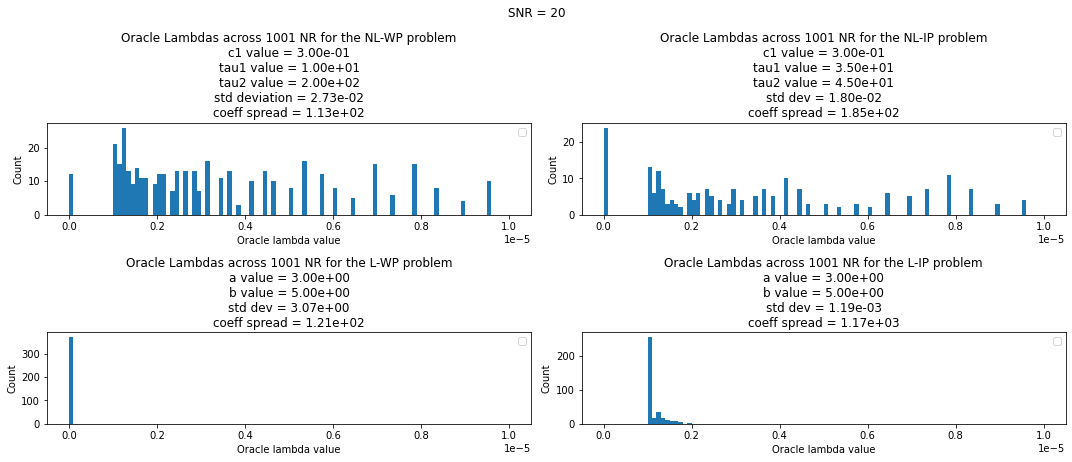

In [20]:
fig, ax = plt.subplots(2,2,figsize=(15,6.5), tight_layout=True)
fig.suptitle("SNR = 20")
NL_IPbinwidth = 0.0001
NL_WPbinwidth = 0.0001
#binwidth2 = 0.01
#NL_IPbins= np.arange(min(lam_NL_IP), max(lam_NL_IP) + NL_IPbinwidth, NL_IPbinwidth)
NL_IPbins = np.arange(0,0.00001,0.0000001)
#NL_WPbins= np.arange(min(lam_NL_WP), max(lam_NL_WP) + NL_WPbinwidth, NL_WPbinwidth)
NL_WPbins = np.arange(0,0.00001,0.0000001)

#bins2 =np.arange(min(lam_NL_WP), max(lam_NL_WP) + binwidth2, binwidth2)
ax[0,0].hist(lam_NL_WP, bins = NL_WPbins)
ax[0,0].set_xlabel("Oracle lambda value")
ax[0,0].set_ylabel("Count")
ax[0,0].set_title("Oracle Lambdas across 1001 NR for the NL-WP problem" + 
          "\nc1 value = " + "{:.2e}".format(c1_trueparam_NLWP) + 
          "\ntau1 value = " + "{:.2e}".format(tau1_trueparam_NLWP) +
          "\ntau2 value = " + "{:.2e}".format(tau2_trueparam_NLWP) +
          "\nstd deviation = " + "{:.2e}".format(st_dev(lam_NL_WP)) +
          "\ncoeff spread = " + "{:.2e}".format(coef_spread(lam_NL_WP)) 
          ) 
ax[0,0].legend()
ax[0,1].hist(lam_NL_IP, bins = NL_IPbins)
ax[0,1].set_xlabel("Oracle lambda value")
ax[0,1].set_ylabel("Count")
ax[0,1].set_title("Oracle Lambdas across 1001 NR for the NL-IP problem" + 
          "\nc1 value = " + "{:.2e}".format(c1_trueparam_NLIP) + 
          "\ntau1 value = " + "{:.2e}".format(tau1_trueparam_NLIP) +
          "\ntau2 value = " + "{:.2e}".format(tau2_trueparam_NLIP) +
          "\nstd dev = " + "{:.2e}".format(st_dev(lam_NL_IP)) +
          "\ncoeff spread = " + "{:.2e}".format(coef_spread(lam_NL_IP))
          )
ax[0,1].legend()
ax[1,0].hist(lam_L_WP, bins = NL_WPbins)
ax[1,0].set_xlabel("Oracle lambda value")
ax[1,0].set_ylabel("Count")
ax[1,0].set_title("Oracle Lambdas across 1001 NR for the L-WP problem" + 
          "\na value = " + "{:.2e}".format(lin_true_params[0]) + 
          "\nb value = " + "{:.2e}".format(lin_true_params[1])+
          "\nstd dev = " + "{:.2e}".format(st_dev(lam_L_WP)) +
          "\ncoeff spread = " + "{:.2e}".format(coef_spread(lam_L_WP))
          )
ax[1,0].legend()
ax[1,1].hist(lam_L_IP, bins = NL_IPbins)
ax[1,1].set_xlabel("Oracle lambda value")
ax[1,1].set_ylabel("Count")
ax[1,1].set_title("Oracle Lambdas across 1001 NR for the L-IP problem" + 
          "\na value = " + "{:.2e}".format(lin_true_params[0]) + 
          "\nb value = " + "{:.2e}".format(lin_true_params[1]) +
          "\nstd dev = " + "{:.2e}".format(st_dev(lam_L_IP)) +
          "\ncoeff spread = " + "{:.2e}".format(coef_spread(lam_L_IP))
          )
ax[1,1].legend()